<a href="https://colab.research.google.com/github/DaniDelgon/TradingRL/blob/main/DeepRL_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import dependencies and data downloading

So, what we are going to do in this notebook is to build a deep reinforcement algorithm to develop trading strategies. This notebook is divided by different parts:

1.   Import and downloading of the data -> Where we are going to install the OHLCV (Close, High, Low, Close, Volume) financial data from the yahoo finance library ib the form of a pandas DataFrame and install a few dependencies that we are going to need.

2.   Feature Engineering -> In this chapter, we are going to use the ta (technical analysis) library to biuld some feature for this dataframe. We are going to study the correlation between these features, removing some of the features which have more correlation between them.

3.   Train/Test Partition -> In this chapter we are going to divide the dataset between train and test dataset in the slicing fashioned way, without randomize the data, because we need the serialization nature of this dataframe to get the patterns of the financial data that we are handling.

4.   Gym Environment Creation -> In the world of reinforcement learning, there are some basic things that we are going to need froam a environment for training a reinforcemet algorithm, some of them are: action variables and space, observation variables and space and reward. The action space is the set of actions that our algorithm could take to interact with the environment, the observation space is the data that our agent is going to see in every step of the training. With the help of the gym library, we are going to create a trading environment for the later training of our deep reinforcement algorithm.
In this environment environment, we are going to implement a method to render the performance of the model every time our model ends the trading session or gets bankrupt.

5.   Training parameter optimization -> In this chapter, we are performing bayesian optimization to get some optimal hyperparameters for the reinforcement learning algorithm.

6.   Training -> With the help of the environment we created before and the sb3 (stables baselines 3) library, we are going to train our deep reinforcement learning algorithm, saving some information of the training with the help of tensorboard for the later visualization of this training performance with some metrics such as Policy Loss, Mean Reward, Episode Length... What we are going to do is to save the model every 10k steps of training.

7.   Test and performance renderization -> After training, we will visualize the performance of the model through the training with tensorboard, and we are going to load the model wihch gets the best Mean Reward in the training processwith the help of tensorboard. Then, we are going to visualize the performance of this model in the test data partition.

8.   Model Performance visualization trough the training process -> Last, we are going to use the render method of our environment to visualize the performance of the model every 10k steps of training, in the training partition of our dataset.


Install of some dependencies and libraries.

In [ ]:
!pip install stable_baselines3
!pip install yfinance
!pip install sb3_contrib
!pip install ta
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 170 kB 16.1 MB/s 
     |████████████████████████████████| 1.5 MB 4.1 MB/s 
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616822 sha256=92516e710e23242627c081c364e43c506117d3d9acb31d6e3dfd2788a441db8a
  Stored in directory: /root/.cache/pip/wheels/27/6d/b3/a3a6e10704795c9b9000f1ab2dc480dfe7bed42f5972806e73
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, htt

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [ ]:
import yfinance as yf
import pandas as pd

ticker='F'
df=yf.download(ticker,start='2020-01-01',end='2023-12-08')    #This is the part where we collect the Close,Open... values of the stock on each day. of the action on each day
df.reset_index(inplace=True)
df['Date']=pd.to_datetime(pd.Series(df['Date']), format='%Y-%m-%d')
final_df = df

[*********************100%***********************]  1 of 1 completed


In [ ]:
final_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,9.29,9.42,9.19,9.42,8.925090,43425700
1,2020-01-03,9.31,9.37,9.15,9.21,8.726123,45040800
2,2020-01-06,9.10,9.17,9.06,9.16,8.678751,43372300
3,2020-01-07,9.20,9.25,9.12,9.25,8.764022,44984100
4,2020-01-08,9.23,9.30,9.17,9.25,8.764022,45994900


#Feature Engineering

In [ ]:
def correlat(dataframe):
  # We are going to study correlations to understand the variables.
  # Calculates Pearson's correlation coefficient
  corr = dataframe.corr(method ='pearson')

  # HeatMap with enlarged size, square, divergence with colours and 2 decimal places annotations
  plt.figure(figsize=(20,12))
  ax = sns.heatmap(
  corr,
  vmin=-1, vmax=1, center=0,
  cmap=sns.diverging_palette(20, 220, n=200),
  square=True, annot=True, fmt=".2f"
  )
  # Rotate the labels on the horizontal axis
  ax.set_xticklabels(
  ax.get_xticklabels(),
  rotation=45,
  horizontalalignment='right'
  )

  plt.show()

In [ ]:
#Import the technical analysis library to perform a fast and easy financial feature engineering of our dataset.
import ta as ta

In [ ]:
#Momentum Indicators

Momentum=pd.DataFrame()

Momentum['AO']=ta.momentum.AwesomeOscillatorIndicator(final_df['High'], final_df['Low']).awesome_oscillator()
Momentum['KAMA']=ta.momentum.KAMAIndicator(final_df['Close']).kama()
Momentum['PPO']=ta.momentum.PercentagePriceOscillator(final_df['Close']).ppo_signal()
Momentum['PVO']=ta.momentum.PercentageVolumeOscillator(final_df['Volume']).pvo_signal()
Momentum['ROC']=ta.momentum.ROCIndicator(final_df['Close']).roc()
Momentum['RSI']=ta.momentum.RSIIndicator(final_df['Close']).rsi()
Momentum['StochRSI']=ta.momentum.StochRSIIndicator(final_df['Close']).stochrsi()
Momentum['SO']=ta.momentum.StochasticOscillator(final_df['High'],final_df['Low'],final_df['Close']).stoch_signal()
Momentum['TSI']=ta.momentum.TSIIndicator(final_df['Close']).tsi()
Momentum['UO']=ta.momentum.UltimateOscillator(final_df['High'],final_df['Low'],final_df['Close']).ultimate_oscillator()
Momentum['WR']=ta.momentum.WilliamsRIndicator(final_df['High'],final_df['Low'],final_df['Close'])

In [ ]:
Momentum.isna().sum()

AO          33
KAMA         9
PPO         33
PVO         33
ROC         12
RSI         13
StochRSI    26
SO          15
TSI         37
UO          28
WR           0
dtype: int64

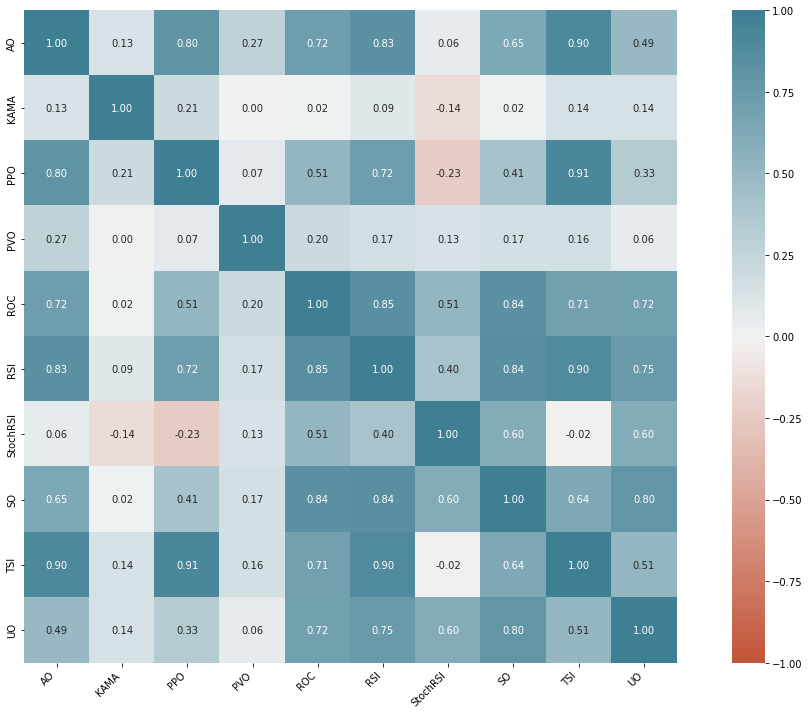

In [ ]:
correlat(Momentum)

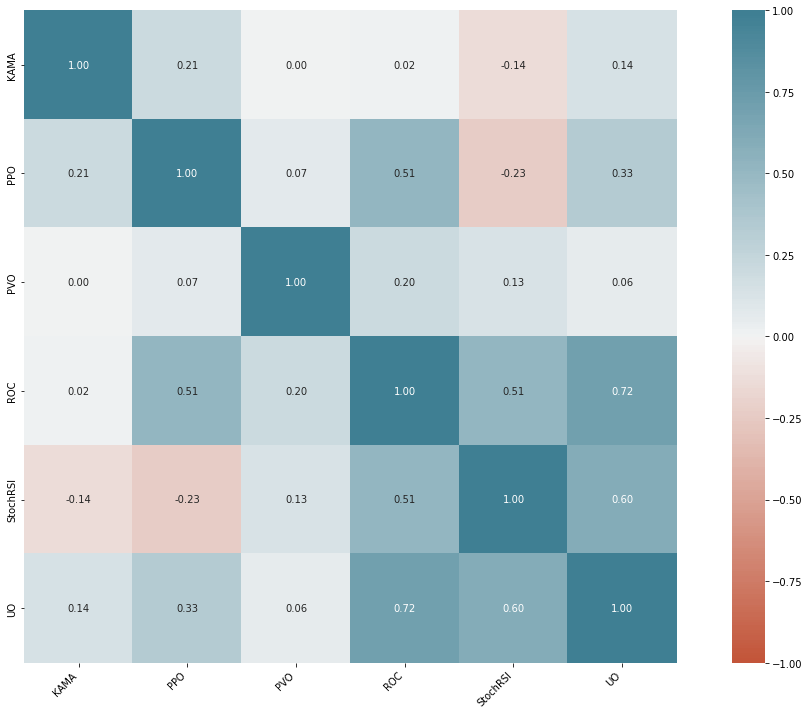

In [ ]:
#Some of the Momentum columns that don´t have a high correlation between them
mom_col=['KAMA','PPO','PVO','ROC','StochRSI','UO']

correlat(Momentum[mom_col])

In [ ]:
#Volume Indicators

Volume=pd.DataFrame()

Volume['ADI']=ta.volume.AccDistIndexIndicator(final_df['High'],final_df['Low'],final_df['Close'],final_df['Volume']).acc_dist_index()
Volume['CMF']=ta.volume.ChaikinMoneyFlowIndicator(final_df['High'],final_df['Low'],final_df['Close'],final_df['Volume']).chaikin_money_flow()
Volume['EOM']=ta.volume.EaseOfMovementIndicator(final_df['High'],final_df['Low'],final_df['Volume']).sma_ease_of_movement()
Volume['FI']=ta.volume.ForceIndexIndicator(final_df['Close'], final_df['Volume']).force_index()
Volume['MFI']=ta.volume.MFIIndicator(final_df['High'],final_df['Low'],final_df['Close'],final_df['Volume']).money_flow_index()
Volume['NVI']=ta.volume.NegativeVolumeIndexIndicator(final_df['Close'], final_df['Volume']).negative_volume_index()
Volume['OBV']=ta.volume.OnBalanceVolumeIndicator(final_df['Close'], final_df['Volume']).on_balance_volume()
Volume['VPT']=ta.volume.VolumePriceTrendIndicator(final_df['Close'], final_df['Volume']).volume_price_trend()
Volume['VWAP']=ta.volume.VolumeWeightedAveragePrice(final_df['High'],final_df['Low'],final_df['Close'],final_df['Volume']).volume_weighted_average_price()

In [ ]:
Volume.isna().sum()

ADI      0
CMF     19
EOM     14
FI      13
MFI     13
NVI      0
OBV      0
VPT      0
VWAP    13
dtype: int64

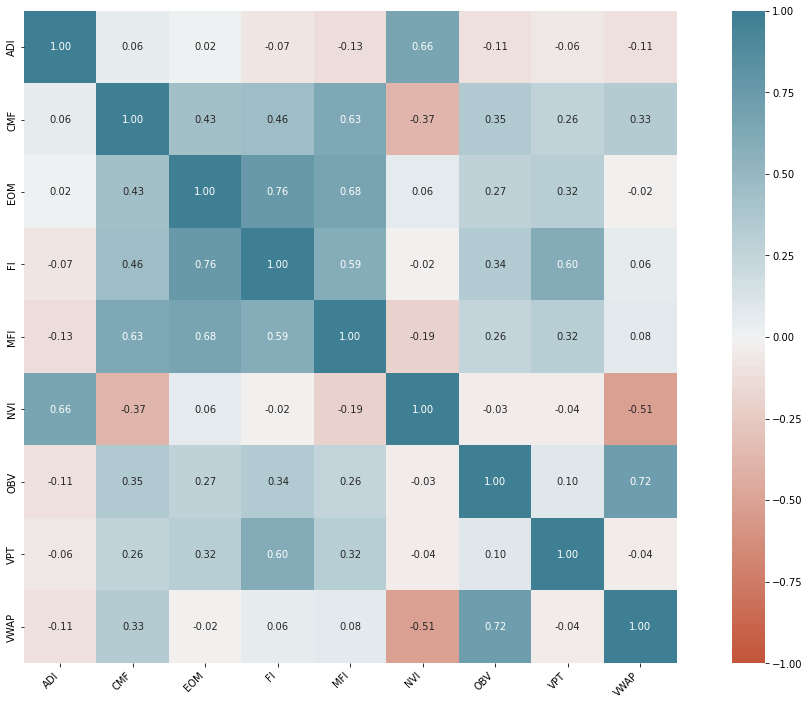

In [ ]:
correlat(Volume)

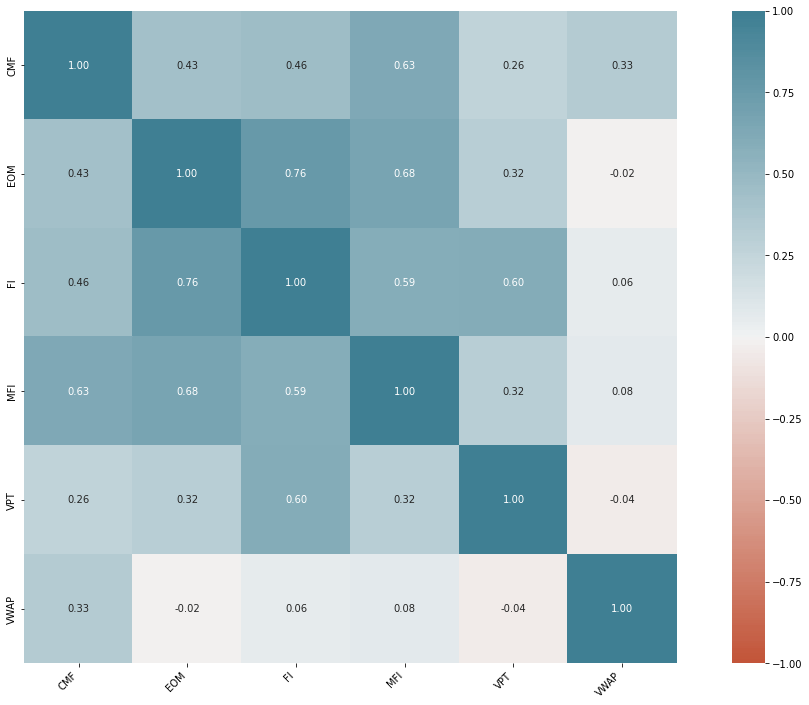

In [ ]:
#Some of the Volume columns that don´t have a high correlation between them
vol_col=['CMF','EOM','FI','MFI','VPT','VWAP']

correlat(Volume[vol_col])

In [ ]:
#Volatility Indicators

Volatility=pd.DataFrame()

Volatility['ATR']=ta.volatility.AverageTrueRange(final_df['High'],final_df['Low'],final_df['Close']).average_true_range()
#Volatility['BB']=ta.volatility.BollingerBands(final_df['Close']).bollinger_mavg()
Volatility['UI']=ta.volatility.UlcerIndex(final_df['Close']).ulcer_index()

In [ ]:
Volatility.isna().sum()

ATR     0
UI     13
dtype: int64

In [ ]:
#Trend Indicators

Trend=pd.DataFrame()

Trend['ADX']=ta.trend.ADXIndicator(final_df['High'],final_df['Low'],final_df['Close']).adx()
Trend['Aroon']=ta.trend.AroonIndicator(final_df['Close']).aroon_indicator()
Trend['CCI']=ta.trend.CCIIndicator(final_df['High'],final_df['Low'],final_df['Close']).cci()
Trend['DPO']=ta.trend.DPOIndicator(final_df['Close']).dpo()
Trend['EMA']=ta.trend.EMAIndicator(final_df['Close']).ema_indicator()
Trend['ICH']=ta.trend.IchimokuIndicator(final_df['High'],final_df['Low']).ichimoku_conversion_line()
Trend['KST']=ta.trend.KSTIndicator(final_df['Close']).kst()
Trend['MACD']=ta.trend.MACD(final_df['Close']).macd()
Trend['MI']=ta.trend.MassIndex(final_df['High'],final_df['Low']).mass_index()
Trend['PSAR']=ta.trend.PSARIndicator(final_df['High'],final_df['Low'],final_df['Close']).psar()
#Trend['SMA']=ta.trend.SMAIndicator(final_df['Close']).sma_indicator()
Trend['STC']=ta.trend.STCIndicator(final_df['Close']).stc()
Trend['TRIX']=ta.trend.TRIXIndicator(final_df['Close']).trix()
Trend['Vortex']=ta.trend.VortexIndicator(final_df['High'],final_df['Low'],final_df['Close']). vortex_indicator_diff()
Trend['WMA']=ta.trend.WMAIndicator(final_df['Close']).wma()

/usr/local/lib/python3.8/dist-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.8/dist-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


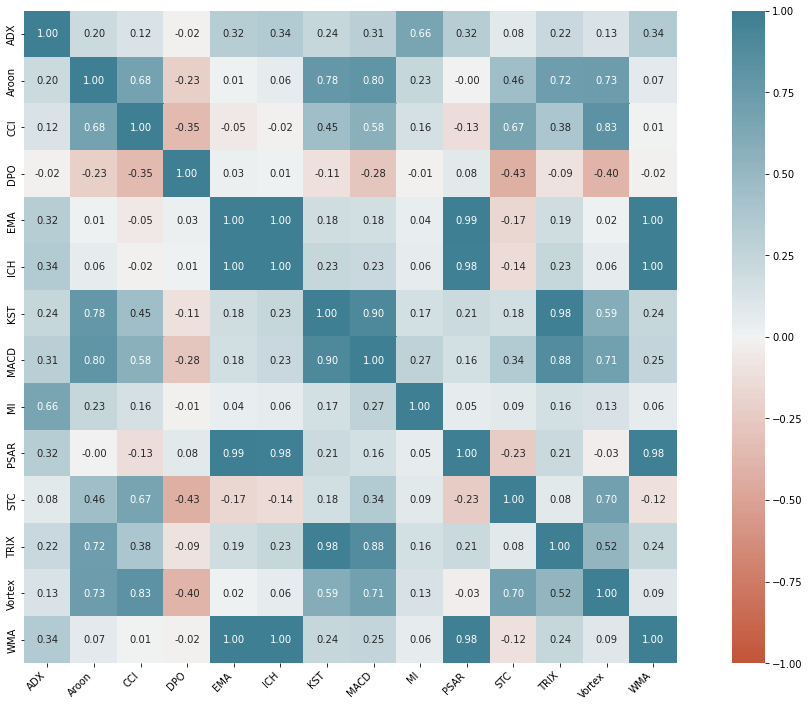

In [ ]:
correlat(Trend)

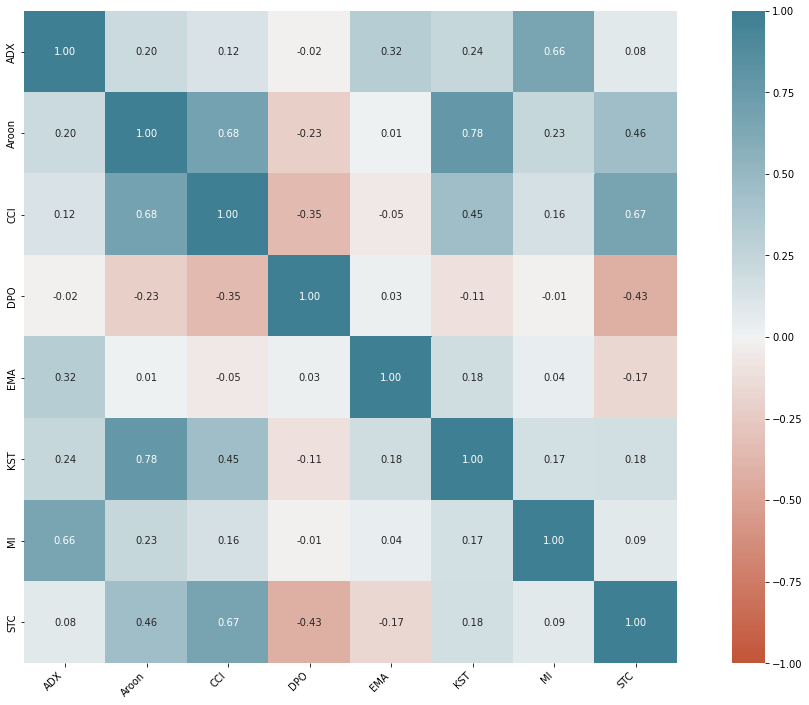

In [ ]:
#Some of the Trend columns that don´t have a high correlation between them
tr_col=['ADX','Aroon','CCI','DPO','EMA','KST','MI','STC']

correlat(Trend[tr_col])

In [ ]:
print(np.shape(final_df))
print(np.shape(Momentum[mom_col]))
Momentum[mom_col].isna().sum()

(740, 7)
(740, 6)


KAMA         9
PPO         33
PVO         33
ROC         12
StochRSI    26
UO          28
dtype: int64

In [ ]:
#Agregation of some of the less correlated data to our Dataframe
final_df = pd.concat([final_df, Momentum[mom_col]], ignore_index=False, sort=False,axis=1)
final_df = pd.concat([final_df, Volume[vol_col]], ignore_index=False, sort=False,axis=1)
final_df = pd.concat([final_df, Volatility], ignore_index=False, sort=False,axis=1)
final_df = pd.concat([final_df, Trend[tr_col]], ignore_index=False, sort=False,axis=1)

In [ ]:
final_df.isna().sum()

Date          0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
KAMA          9
PPO          33
PVO          33
ROC          12
StochRSI     26
UO           28
CMF          19
EOM          14
FI           13
MFI          13
VPT           0
VWAP         13
ATR           0
UI           13
ADX           0
Aroon        24
CCI          19
DPO          19
EMA          13
KST          14
MI           40
STC          71
dtype: int64

In [ ]:
#Remove of the NaN values produced by rolling means, standard deviations...
final_df = final_df.dropna()
final_df = final_df.reset_index(drop=True)

In [ ]:
final_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,KAMA,PPO,PVO,...,ATR,UI,ADX,Aroon,CCI,DPO,EMA,KST,MI,STC
0,2020-04-15,5.06,5.14,4.95,5.03,4.846783,74727700,4.956260,-8.514365,3.776741,...,0.444176,14.116191,26.844763,-32.0,39.391111,0.2265,5.000725,-192.495485,26.303191,100.0
1,2020-04-16,5.06,5.07,4.89,4.94,4.760061,58951200,4.955409,-7.868859,1.808446,...,0.425306,13.610770,25.111950,-24.0,21.983698,0.0045,4.992628,-172.480188,26.040039,100.0
2,2020-04-17,5.17,5.28,5.03,5.12,4.933505,91989300,4.968348,-7.233838,0.165147,...,0.419213,12.881486,23.629738,-24.0,51.266445,-0.4580,5.009611,-149.062523,25.698024,100.0
3,2020-04-20,5.01,5.09,4.91,4.98,4.798604,71079400,4.969215,-6.666453,-1.530765,...,0.404269,12.416478,21.955203,8.0,16.485837,-0.5305,5.005663,-124.390227,25.153154,100.0
4,2020-04-21,4.89,4.92,4.72,4.77,4.596253,82400200,4.965602,-6.223070,-2.996421,...,0.393964,12.192775,20.830621,8.0,-37.200892,-0.6885,4.974241,-106.623280,24.786806,100.0


#Train/Test Partition

In [ ]:
# Choose the partition size, and divide the dataset in train and test datasets
size_test_portion=0.1

index_partition=int(len(final_df)*(1-size_test_portion))
train_df=final_df[:index_partition]
test_df=final_df[index_partition:]

In [ ]:
train_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,KAMA,PPO,PVO,...,ATR,UI,ADX,Aroon,CCI,DPO,EMA,KST,MI,STC
0,2020-04-15,5.06,5.14,4.95,5.03,4.846783,74727700,4.956260,-8.514365,3.776741,...,0.444176,14.116191,26.844763,-32.0,39.391111,0.2265,5.000725,-192.495485,26.303191,100.0
1,2020-04-16,5.06,5.07,4.89,4.94,4.760061,58951200,4.955409,-7.868859,1.808446,...,0.425306,13.610770,25.111950,-24.0,21.983698,0.0045,4.992628,-172.480188,26.040039,100.0
2,2020-04-17,5.17,5.28,5.03,5.12,4.933505,91989300,4.968348,-7.233838,0.165147,...,0.419213,12.881486,23.629738,-24.0,51.266445,-0.4580,5.009611,-149.062523,25.698024,100.0
3,2020-04-20,5.01,5.09,4.91,4.98,4.798604,71079400,4.969215,-6.666453,-1.530765,...,0.404269,12.416478,21.955203,8.0,16.485837,-0.5305,5.005663,-124.390227,25.153154,100.0
4,2020-04-21,4.89,4.92,4.72,4.77,4.596253,82400200,4.965602,-6.223070,-2.996421,...,0.393964,12.192775,20.830621,8.0,-37.200892,-0.6885,4.974241,-106.623280,24.786806,100.0


In [ ]:
test_df.reset_index(drop=True,inplace=True)

In [ ]:
test_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,KAMA,PPO,PVO,...,ATR,UI,ADX,Aroon,CCI,DPO,EMA,KST,MI,STC
0,2022-09-02,15.53,15.57,15.06,15.16,15.003173,64565400,15.423837,3.312367,-4.580000,...,0.510586,5.630382,29.575482,-16.0,-77.974431,0.4920,15.404672,147.655952,25.095470,0.097656
1,2022-09-06,15.22,15.24,14.84,15.03,14.874517,58676700,15.421375,2.977968,-4.151825,...,0.502687,5.927604,27.935922,-56.0,-109.414396,0.2595,15.354716,132.934718,24.815692,0.048828
2,2022-09-07,14.91,15.49,14.79,15.43,15.270380,55087200,15.421452,2.693561,-3.869088,...,0.516781,6.011057,26.848681,-56.0,-69.817717,-0.5525,15.364754,119.009137,24.775371,0.024414
3,2022-09-08,15.16,15.48,15.02,15.47,15.309966,60075900,15.421755,2.453386,-3.547549,...,0.512725,6.043257,25.839100,-56.0,-51.966227,-0.3110,15.378787,105.750920,24.686343,0.012207
4,2022-09-09,15.60,15.70,15.32,15.42,15.260483,63328600,15.421651,2.242713,-3.122467,...,0.503244,6.037603,25.290898,-56.0,-20.852691,-0.0905,15.384282,91.226493,24.645657,0.006104


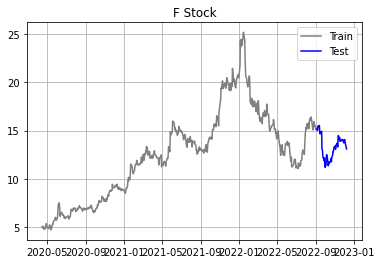

In [ ]:
import matplotlib.pyplot as plt

#Visualization of the train and test datasets
plt.plot(train_df['Date'],train_df['Close'],color='gray',label='Train')
plt.plot(test_df['Date'],test_df['Close'],color='blue',label='Test')
plt.legend()
plt.title(ticker+' Stock')
plt.grid()
plt.show()

#Gym environment creation

In [ ]:
import torch
import random
import numpy as np

#Seed for reproducibility
def reprod(seed):
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)

seed=0

In [ ]:
#Function to get the Normalization Vector on the dataframe we are going to feed to the algorithm
def get_normalization(df,scale_factor):
  N_vect=df.values.max(0)[None, 1:][0]
  return N_vect*scale_factor

In [ ]:
import json
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

TRANSACTION_COST=0.0075
INITIAL_ACCOUNT_BALANCE = 10000

class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df, serial,lookback_window_size=12):
        super(StockTradingEnv, self).__init__()
        reprod(seed)

        self.df = df
        self.lookback_window_size = lookback_window_size     #Lookback for the window of data we are gonna feed our model every step
        self.serial=serial                                   #Variable to set the start step to the first step of the dataset or randomize the starting point in the dataset
        self.N_vect=get_normalization(final_df,1.5)          #Normalization vector for the feature engineering and the OCHLV data

        #Lists for the renderization of the performance
        self.profit_history=[]
        self.balance_history=[]
        self.net_worth_history=[]
        self.shares_held_history=[]
        self.buy_signals=[]
        self.sell_signals=[]
        self.action_done_list=[]
        self.action_list=[]

        self.action_done=True                           #Variable that tells us when an action is performed or not, because you cannot sell shares if you dont haves shares in your property

        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.action_space = spaces.Box(
            low=np.array([0, 0]), high=np.array([3, 1]), dtype=np.float16)

        # Prices contains the OHCL values for the last n lookback_window_size prices
        self.observation_space = spaces.Box(low=-1, high=1, shape=(np.shape(df)[1]+4,self.lookback_window_size), dtype=np.float16)  


    def _next_observation(self):
        # Get the stock data points for the last 5 days and scale to between -1 and 1

        obs=np.transpose((self.df.loc[self.current_step-self.lookback_window_size: self.current_step-1].values[:,1:]/self.N_vect).astype(np.float16))
        
        # Append additional data and scale each value to between 0 and 1

        obs = np.append(obs, self.account_history[:, -self.lookback_window_size:], axis=0)
        return obs

    def _take_action(self, action):
        # Set the current price to a random price within the time step
        self.current_price = random.uniform(
            self.df.loc[self.current_step, "Open"], self.df.loc[self.current_step, "Close"])
        
        action_type = action[0]       #buy, sell or hold
        amount = action[1]            #Percentage of buy and sell
        prev_balance=self.balance     #balance before performing action

        if action_type<1:             #buy action
          quantity=int(self.balance/self.current_price)
          quantity=int(quantity*amount)
          allocated_money=quantity*self.current_price
          money_end=self.balance-allocated_money-TRANSACTION_COST*quantity
          if money_end>=0 and quantity>0:
            # The buying have been done
            self.shares_held+=quantity
            self.balance=money_end
            prev_cost = self.cost_basis * self.shares_held
            self.cost_basis = (
                prev_cost + allocated_money) / (self.shares_held + quantity)
            self.action_done=True
          else:            
            self.action_done=False
        elif action_type<2:       #sell action
          quantity=int(self.shares_held*amount)
          if (quantity<=self.shares_held and quantity!=0):
            # There is enough shares in the portfolio to perform the selling action
            allocated_money=quantity*self.current_price
            self.balance=self.balance+allocated_money-TRANSACTION_COST*quantity
            self.shares_held-=quantity
            self.total_shares_sold += quantity
            self.total_sales_value += quantity * self.current_price
            self.action_done=True
          else:
            self.action_done=False
        else:         #hold action
          self.action_done=True
          pass

        self.net_worth = self.balance + self.shares_held * self.current_price

        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth

        if self.shares_held == 0:
            self.cost_basis = 0

        self.account_history = np.append(self.account_history, [     #Updating of the parameters of our account history
          [self.net_worth],
          [self.shares_held],
          [self.cost_basis],
          [self.balance],
          [self.balance-prev_balance]
        ], axis=1)/self.norm_vect

    def step(self, action):
        # Execute one time step within the environment
        prev_net_worth=self.net_worth         #net worth before performing action
        self._take_action(action)

        self.current_step += 1
        done = self.net_worth <= 0     #If done is True, we are at the end of our episode/trading session

        if self.current_step >= len(self.df.loc[:, 'Open'].values)-1:
            self.current_step = self.lookback_window_size
            done=True

        if self.action_done:
          self.reward = self.net_worth-prev_net_worth     #reward at every step
        else:
          self.reward=0    #negative reward for when our algorithm makes an action it cannot make, like selling shares when not having shares in property
        
        obs = self._next_observation()

        return obs, self.reward, done, {}

    def reset(self):
        
        # Reset the state of the environment to an initial state
        self.balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.max_net_worth = INITIAL_ACCOUNT_BALANCE
        self.shares_held = 0
        self.cost_basis = 0
        self.total_shares_sold = 0
        self.total_sales_value = 0

        self.buy_signals=[]
        self.sell_signals=[]
        self.action_done_list=[]
        self.action_list=[]
        self.profit_history=[]
        self.balance_history=[]
        self.net_worth_history=[]
        self.shares_held_history=[]
        self.action_done=True

        self.norm_vect = np.array([    #Normalization vector for the account history part
          [self.max_net_worth],
          [500],
          [self.max_net_worth],
          [self.max_net_worth],
          [1000]])

        self.account_history = np.repeat([
          [self.net_worth],
          [self.shares_held],
          [self.cost_basis],
          [self.balance],
          [0.1]
        ], self.lookback_window_size + 1, axis=1)/self.norm_vect

        # Set the current step to a random point within the data frame
        if self.serial==True:
          self.current_step = self.lookback_window_size
          self.start_step=self.current_step
        elif self.serial==False:
          self.current_step=np.random.randint(self.lookback_window_size, len(self.df))
          self.start_step=self.current_step

        #print(self.current_step)

        return self._next_observation()

    def render(self, action, done, mode='human', close=False):
        # Render the environment to the screen at the end of every episode
        profit = self.net_worth - INITIAL_ACCOUNT_BALANCE

        action_type = action[0]
        amount = action[1]

        #Adition of account variables to list at every step of the episode
        self.profit_history.append(profit)
        self.balance_history.append(self.balance)
        self.net_worth_history.append(self.net_worth)
        self.shares_held_history.append(self.shares_held)
        if action_type<1 and self.action_done:
          self.action_list.append(0)
          self.buy_signals.append(self.df['Close'][self.current_step])   #self.current_price)
          self.sell_signals.append(np.nan)
        elif action_type<2 and self.action_done:
          self.action_list.append(1)
          self.buy_signals.append(np.nan)
          self.sell_signals.append(self.df['Close'][self.current_step])     #self.current_price)
        else:
          if self.action_done:
            self.action_list.append(2)
          self.buy_signals.append(np.nan)
          self.sell_signals.append(np.nan)

        if self.action_done:
          self.action_done_list.append(1)
        else:
          self.action_done_list.append(0)
        
        if len(np.unique(self.buy_signals))>1 and done==True:   #When episode is done, display the performance in plots
          fig=plt.figure(figsize=(20,35))

          fig.add_subplot(6,2,1)
          plt.plot(self.df['Date'][self.start_step+1:],self.profit_history)
          plt.title('Profit')
          plt.grid()

          fig.add_subplot(6,2,2)
          plt.plot(self.df['Date'][self.start_step+1:],self.balance_history)
          plt.title('Balance')
          plt.grid()

          fig.add_subplot(6,2,3)
          plt.plot(self.df['Date'][self.start_step+1:],self.net_worth_history)
          plt.ylim(0,self.max_net_worth)
          plt.title('Net Worth')
          plt.grid()

          fig.add_subplot(6,2,4)
          plt.plot(self.df['Date'][self.start_step+1:],self.shares_held_history)
          plt.title('Shares Held')
          plt.grid()

          fig.add_subplot(6,2,5)
          plt.plot(self.df['Date'],self.df['Close'])
          plt.plot(self.df['Date'][self.start_step+1:],self.buy_signals,label='Buy',marker='^',color='green')#,s=100)
          plt.plot(self.df['Date'][self.start_step+1:],self.sell_signals,label='Sell',marker='v',color='red')#,s=100)
          plt.title('$F')
          plt.legend()
          plt.grid()

          fig.add_subplot(6,2,6)
          plt.hist(self.action_done_list)
          plt.title('No of legal moves during episode')
          plt.grid()

          fig.add_subplot(6,2,7)
          plt.hist(self.action_list)
          plt.title('Buying vs Selling vs Holding')
          plt.grid()

          plt.show()
        elif done==True:          #When any trades are performed during the episode we only print a phrase informing of that case
          print('NO TRADES DONE')

        #Debugging shell to prove that the actions are performed correctly
        '''       
        print('Date: '+ str(self.df['Date'][self.current_step]))
        print(f'Step: {self.current_step}')
        print(f'Action: {action}')
        print(f'Action Done: {self.action_done}')
        print(f'Reward: {self.reward}')
        print(f'Balance: {self.balance}')
        print(
            f'Shares held: {self.shares_held} (Total sold: {self.total_shares_sold})')
        print(
            f'Avg cost for held shares: {self.cost_basis} (Total sales value: {self.total_sales_value})')
        print(
            f'Net worth: {self.net_worth} (Max net worth: {self.max_net_worth})')
        print(f'Profit: {profit}')
        print('___________________________')
        '''

In [ ]:
import os

#We create the directories where we will save the tensorboard logs and the models
root_path='/content/'
models_dir = root_path+"models/DQN"
logdir=root_path+'logs'

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

#Training hyperparameters optimization

In [ ]:
import optuna
from sb3_contrib import RecurrentPPO

def optimize_ppo2(trial):     #Set the range of the hyperparameters we are going to test
    return {
        #'n_steps': int(trial.suggest_loguniform('n_steps', 16, 2048)),
        'gamma': trial.suggest_loguniform('gamma', 0.9, 0.9999),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1.),
        'ent_coef': trial.suggest_loguniform('ent_coef', 1e-8, 1e-1),
        'clip_range': trial.suggest_uniform('clip_range', 0.1, 0.4),
        'n_epochs': int(trial.suggest_loguniform('n_epochs', 1, 48)),
        'gae_lambda': trial.suggest_loguniform('gae_lambda', 0.9, 0.9999),
        'vf_coef': trial.suggest_loguniform('vf_coef', 1e-8, 1),
        'max_grad_norm': trial.suggest_loguniform('max_grad_norm', 1e-8, 1)
    }

def objective_fn(trial):      #Optimization of the parameters based in the reward performance
    agent_params = optimize_ppo2(trial)
    
    train_env, validation_env = StockTradingEnv(train_df,serial=True),StockTradingEnv(test_df,serial=True)
    model = RecurrentPPO('MlpLstmPolicy', train_env, **agent_params)
    
    try:
      model.learn(len(train_env.df))
    except Exception:
        pass
    
    rewards, done = [], False
    total_reward=0

    obs = validation_env.reset()
    for i in range(len(validation_env.df)):
        action, _ = model.predict(obs)
        obs, reward, done, _ = validation_env.step(action)
        total_reward += reward
        rewards.append(total_reward)
    
    return -np.mean(rewards)

def optimize(n_trials, n_jobs = 4):
    study = optuna.create_study(study_name='optimize_profit', storage='sqlite:///params.db', load_if_exists=True)
    study.optimize(objective_fn, n_trials=n_trials, n_jobs=n_jobs)

In [ ]:
optimize(n_trials=200)

In [ ]:
study = optuna.load_study(study_name='optimize_profit', storage='sqlite:///params.db')
params = study.best_trial.params

train_env=StockTradingEnv(train_df,serial=True)

model_params = {                   #set the best parameters from the parameter optimization
    #'n_steps': int(params['n_steps']),
    'gamma': params['gamma'],
    'learning_rate': params['learning_rate'],
    'ent_coef': params['ent_coef'],
    'clip_range': params['clip_range'],
    'n_epochs': int(params['n_epochs']),
    'gae_lambda': params['gae_lambda'],
    'vf_coef': params['vf_coef'],
    'max_grad_norm': params['max_grad_norm']
}

#model = RecurrentPPO('MlpLstmPolicy', train_env, **model_params)

#Training the model

In [ ]:
import torch as th
import torch.nn as nn
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

#We create a simple feature extractor for the model
class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 64):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        # We assume CxHxW images (channels first)
        # Re-ordering will be done by pre-preprocessing or wrapper
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv1d(33, features_dim, kernel_size=1, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv1d(features_dim, 33, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Flatten(),     ###
        )

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))

policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=64),
)

En la siguiente celda podemos observar un ejemplo de acción y de observación del modelo en cuestión.

Entrenamos el modelo en la siguiente celda y visualizamos un episodio sin entrenar nada el modelo.

In [ ]:
import gym
import json
import datetime as dt

from stable_baselines3.common.vec_env import DummyVecEnv
from sb3_contrib import RecurrentPPO

# The algorithms require a vectorized environment to run
#env = DummyVecEnv([lambda: StockTradingEnv(df)])
train_env=StockTradingEnv(train_df,serial=False)
train_env.reset()

model1 = RecurrentPPO('MlpLstmPolicy', train_env, verbose=1,policy_kwargs=policy_kwargs,tensorboard_log=logdir,seed=seed, **model_params)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
# sample action:
print("sample action:", train_env.action_space.sample())

# observation space shape:
print("observation space shape:", train_env.observation_space.shape)

# sample observation:
print("sample observation:", train_env.observation_space.sample())

sample action: [0.1631 0.9653]
observation space shape: (33, 12)
sample observation: [[ 0.06305   0.4797    0.4102    0.3115    0.6157   -0.2404    0.3496
  -0.677    -0.838     0.452     0.3694   -0.281   ]
 [ 0.1332   -0.1273   -0.4773    0.287     0.509     0.3108   -0.8965
  -0.616     0.807    -0.408     0.363    -0.4539  ]
 [-0.445    -0.9727   -0.626     0.11554   0.8774    0.4883    0.6465
   0.252    -0.4019   -0.91      0.2009   -0.1279  ]
 [-0.331     0.6465   -0.1177   -0.6763    0.265    -0.7637    0.5913
  -0.134    -0.4297    0.7197    0.457    -0.9585  ]
 [-0.356    -0.717    -0.838     0.463     0.961    -0.1349   -0.6
   0.8486   -0.3218   -0.321     0.44      0.6826  ]
 [-0.8203   -0.3186    0.1865   -0.4119    0.2443    0.802    -0.377
   0.9253   -0.9326   -0.03198   0.919     0.4307  ]
 [ 0.537     0.3682    0.964     0.642     0.00411   0.0986    0.04196
  -0.232    -0.1181    0.711     0.5674    0.7563  ]
 [ 0.695    -0.9883   -0.132    -0.04962   0.4407    0.35

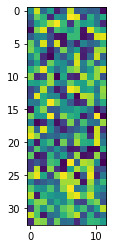

In [ ]:
#Visualization of an observation space sample
sample=np.asarray(train_env.observation_space.sample(), dtype=np.float32)
plt.imshow(sample)
plt.show()

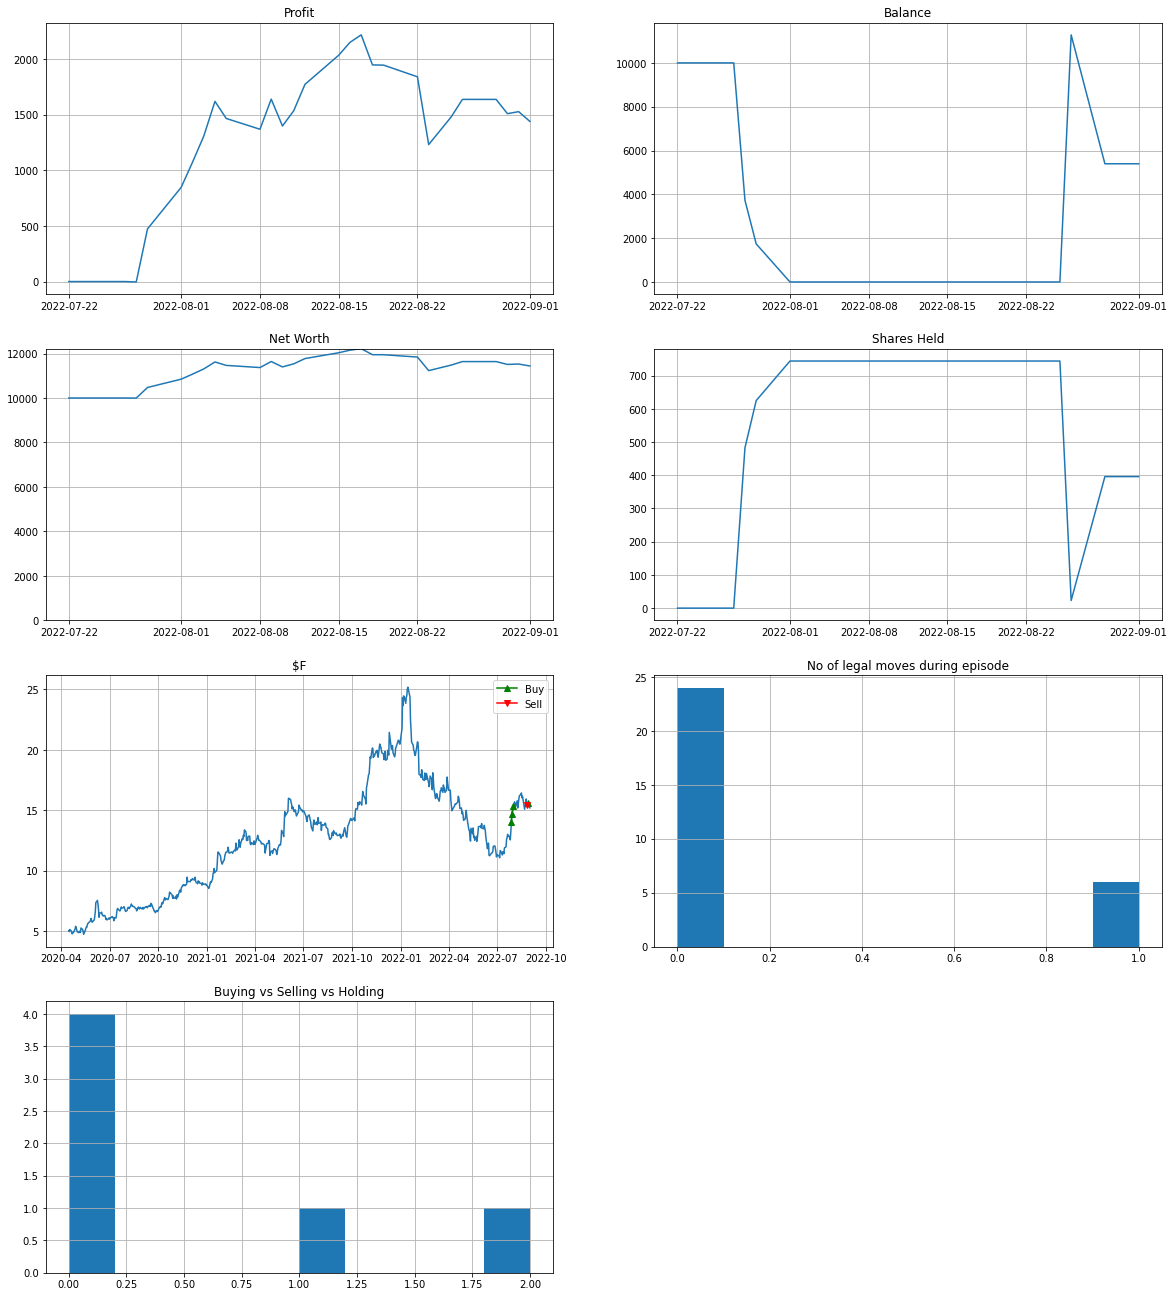

In [ ]:
obs = train_env.reset()         #We run a trading session of the model without the training
done=False
while not done:
    action, _states = model1.predict(obs)
    obs, rewards, done, info = train_env.step(action)
    train_env.render(action,done)

In [ ]:
train_env.reset()        #Training of the model for 10 million steps, but for this notebook, we are going to run 200k steps
TIMESTEPS = 10000
for i in range(1,1001):
    model1.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False,tb_log_name="DQN1")
    model1.save(f'{models_dir}/DQN1/{TIMESTEPS*i}')

In [ ]:
while True:
  model1.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name="DQN1")
  model1.save(f'{models_dir}/DQN1/{TIMESTEPS*i}')
  i+=1
  if i==1001:
    break

#Test and render the efficiency of the model.

In [ ]:
#!kill 352

In [ ]:
# Load the TensorBoard notebook extension for visualization of the efficiency of the model over the training period, and picking the best n-step model in terms of mean reward
%load_ext tensorboard
%tensorboard --logdir logs

/usr/local/lib/python3.8/dist-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(


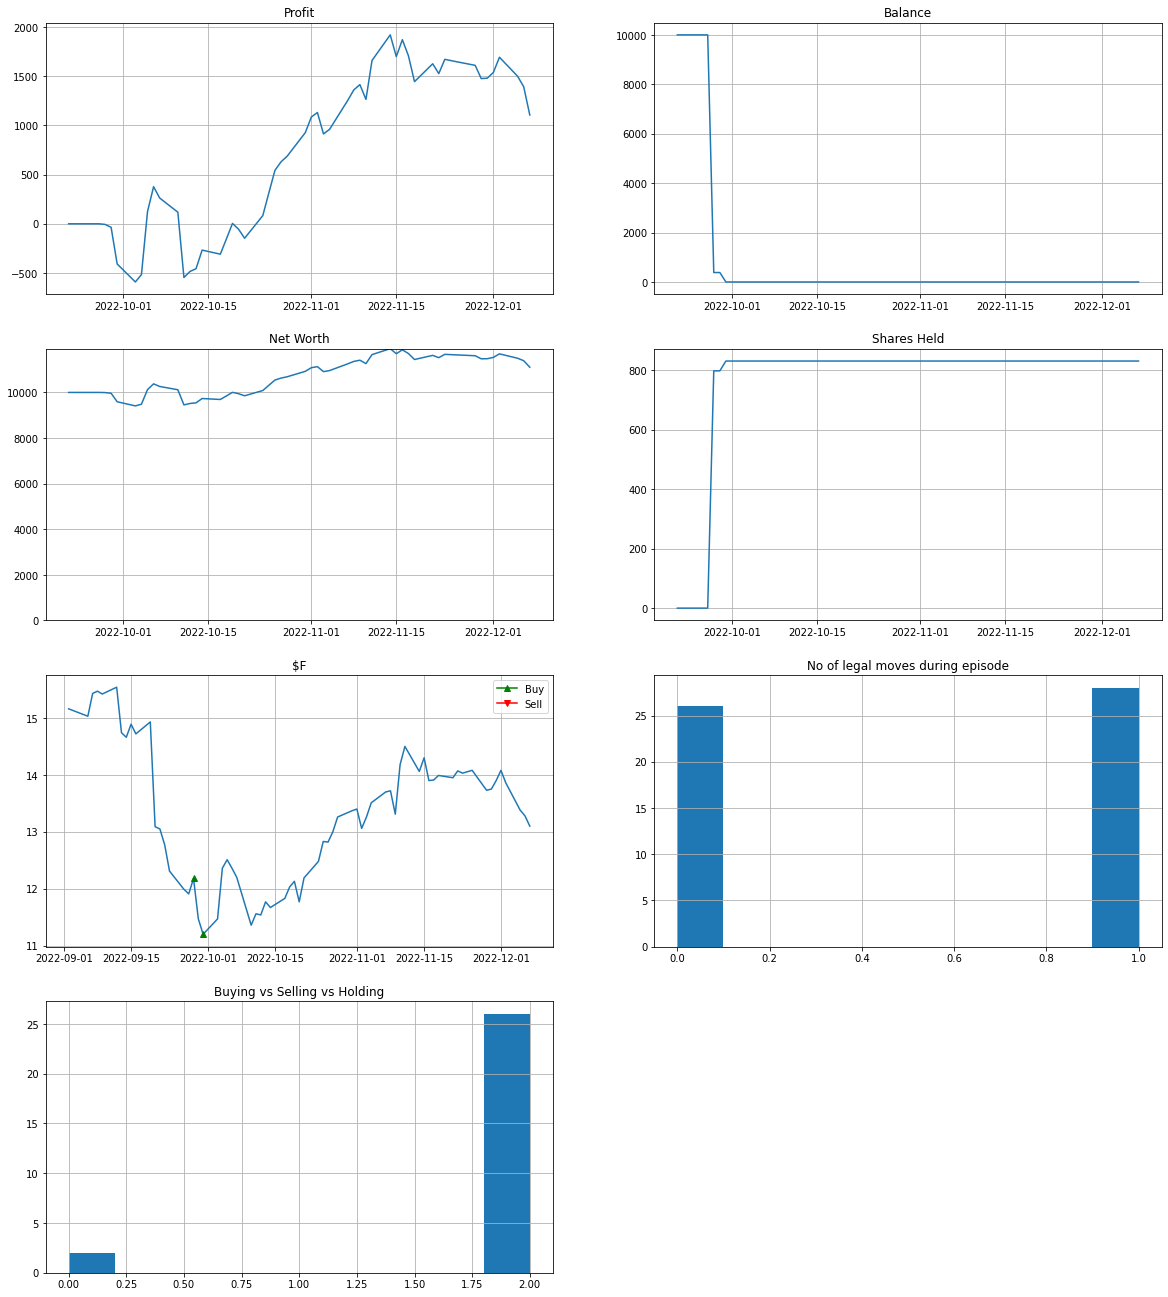

In [ ]:
test_env=StockTradingEnv(test_df,serial=True)         #We load the model with the best mean reward (that we have chosed from tensorboard) over the training period and run it on the test data
model=RecurrentPPO.load(f'{models_dir}/DQN1/40000.zip', **model_params)

obs = test_env.reset()
done=False
while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, info = test_env.step(action)
    test_env.render(action,done)

#Prove of the learning of the model over training steps

/usr/local/lib/python3.8/dist-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(


-------------------------
10000


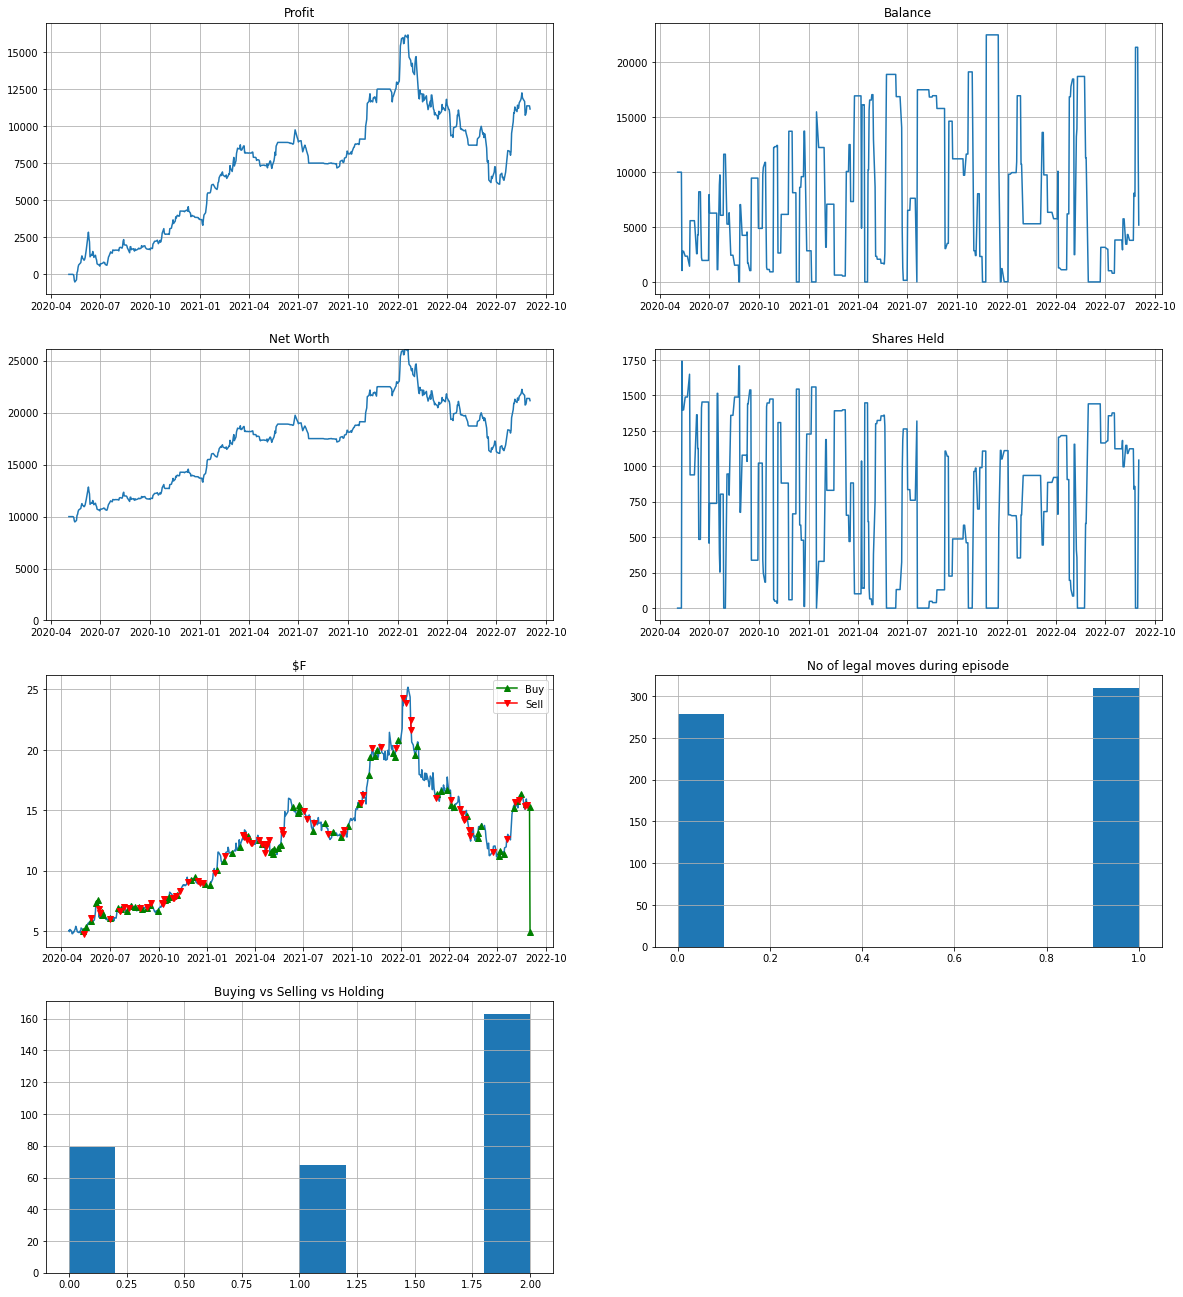

-------------------------
20000


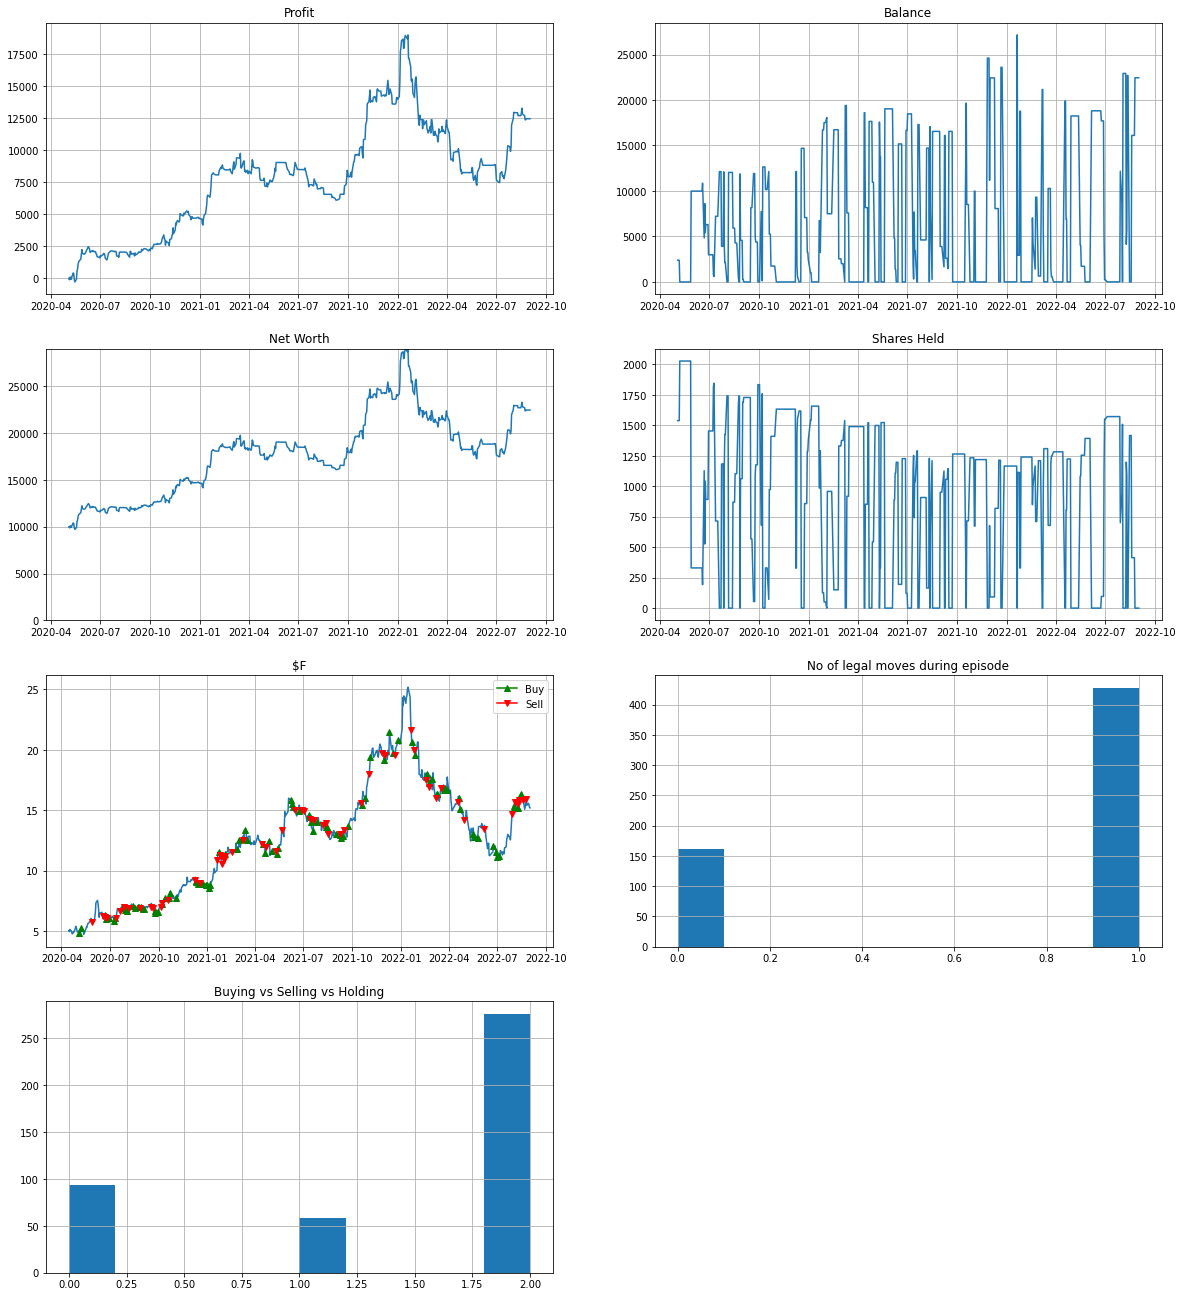

-------------------------
30000


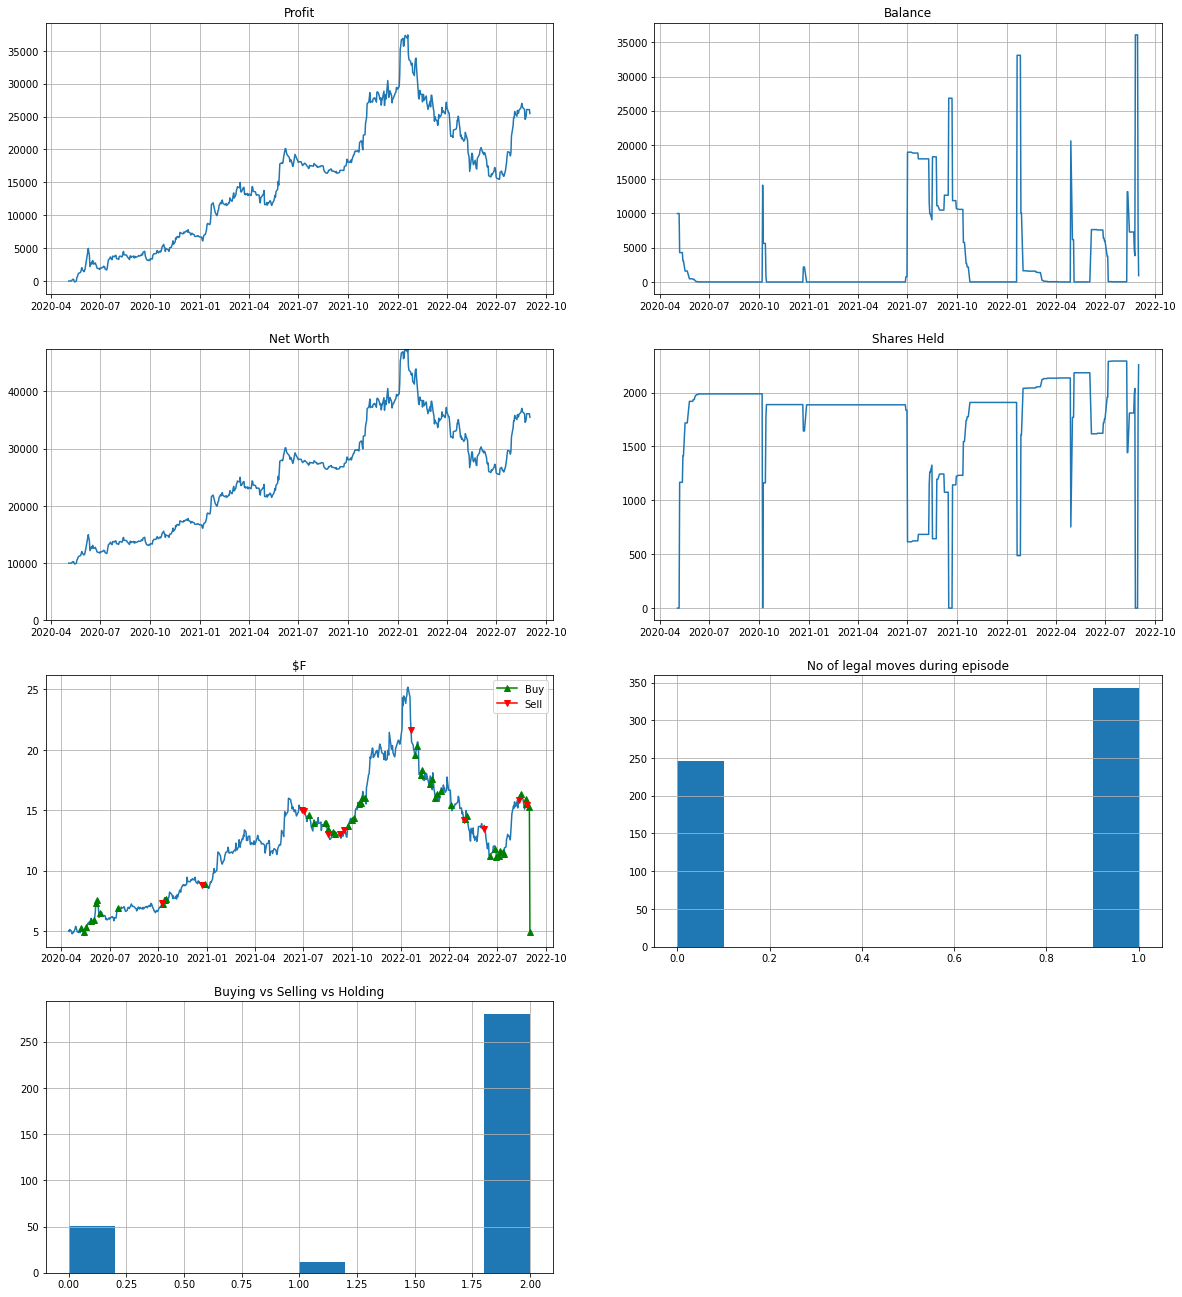

-------------------------
40000


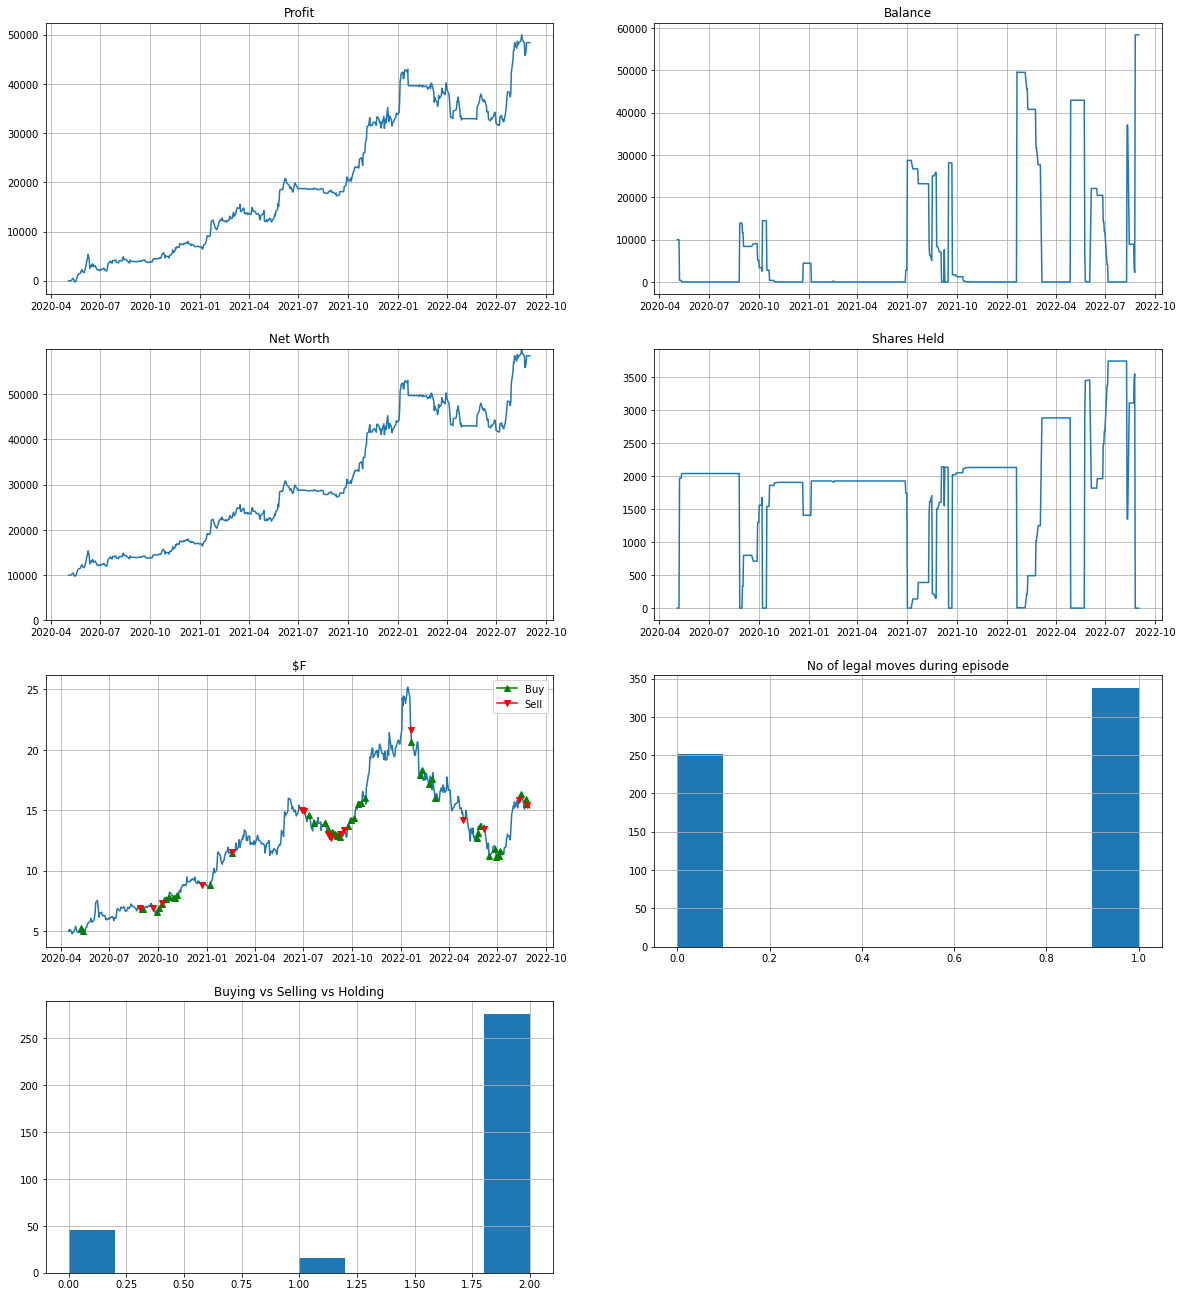

-------------------------
50000


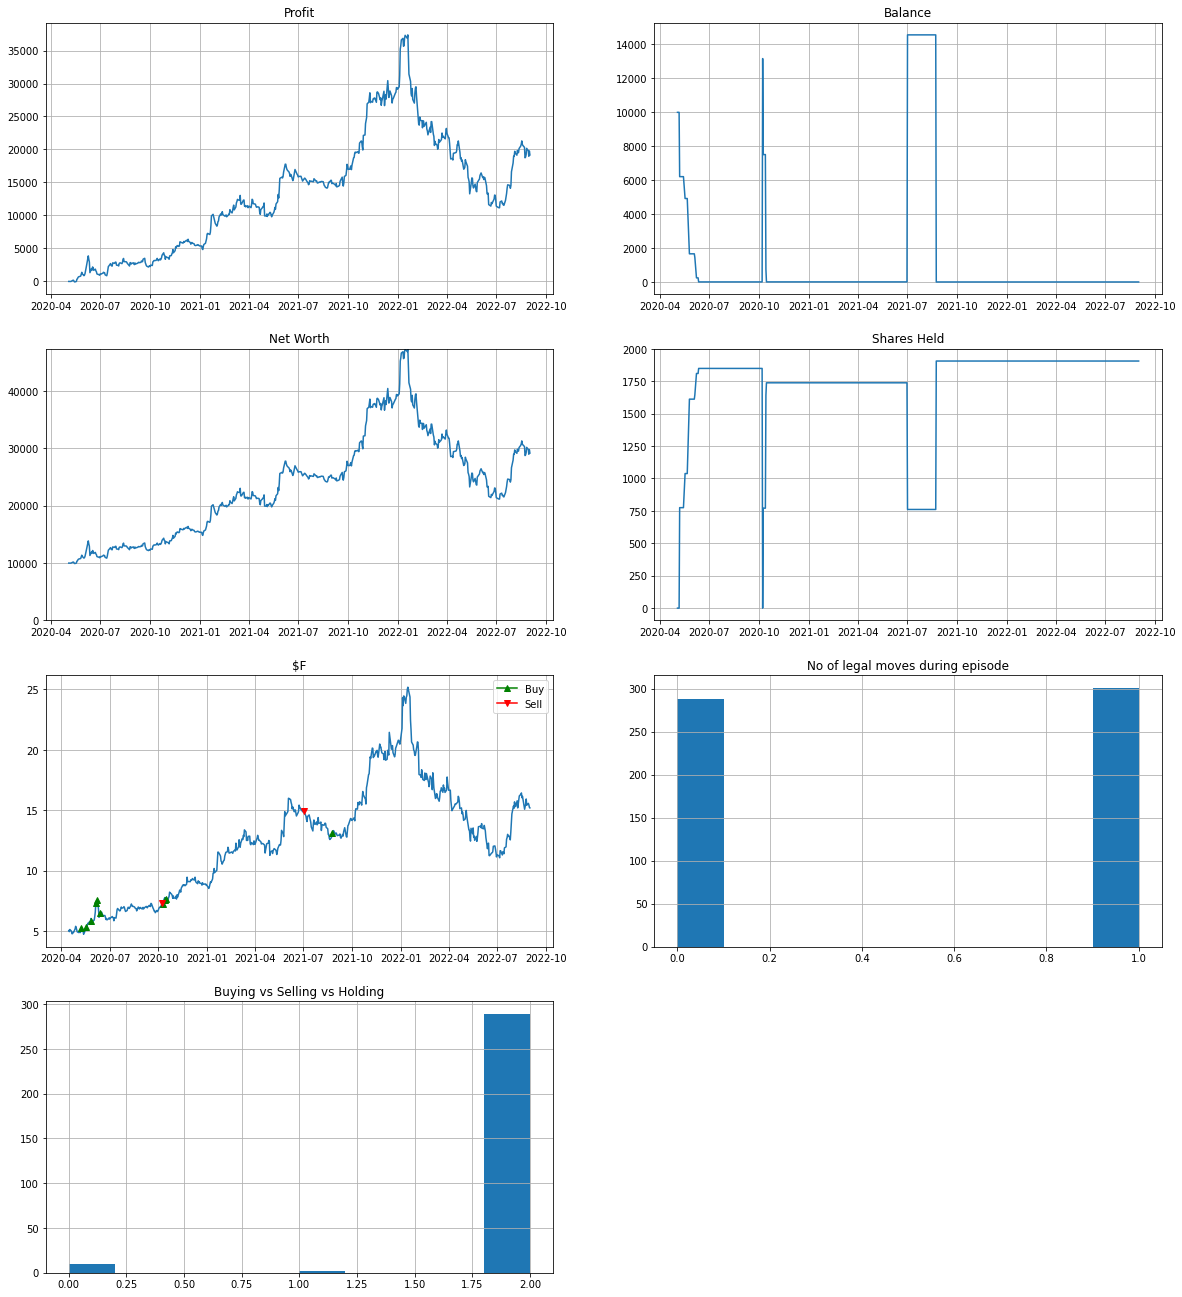

-------------------------
60000


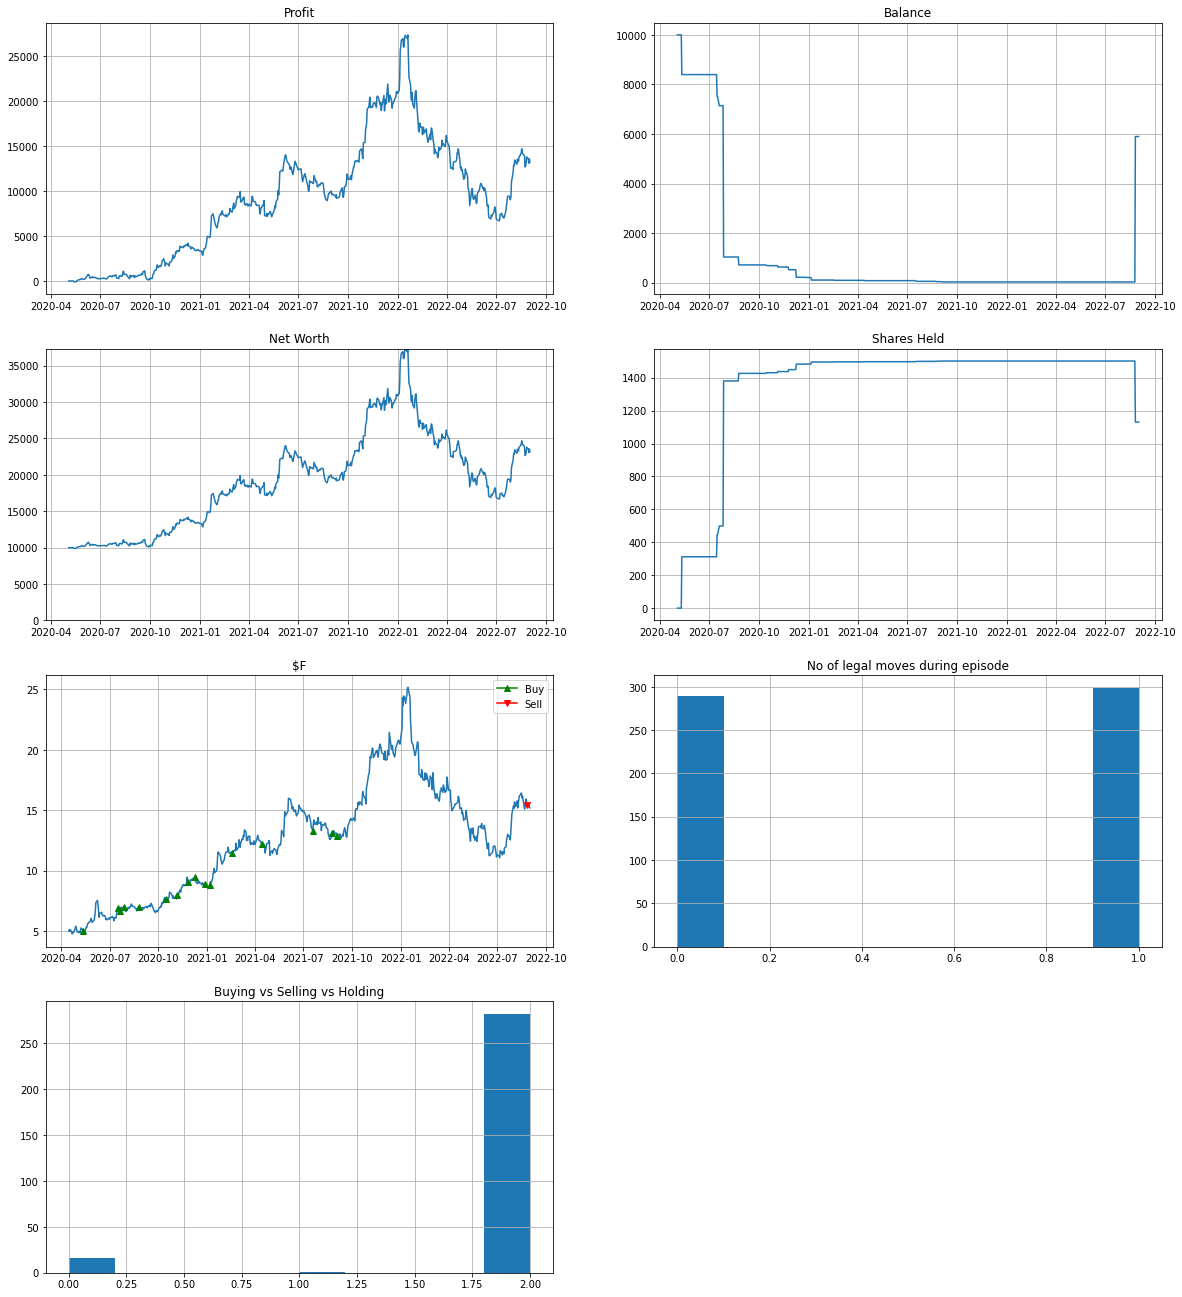

-------------------------
70000


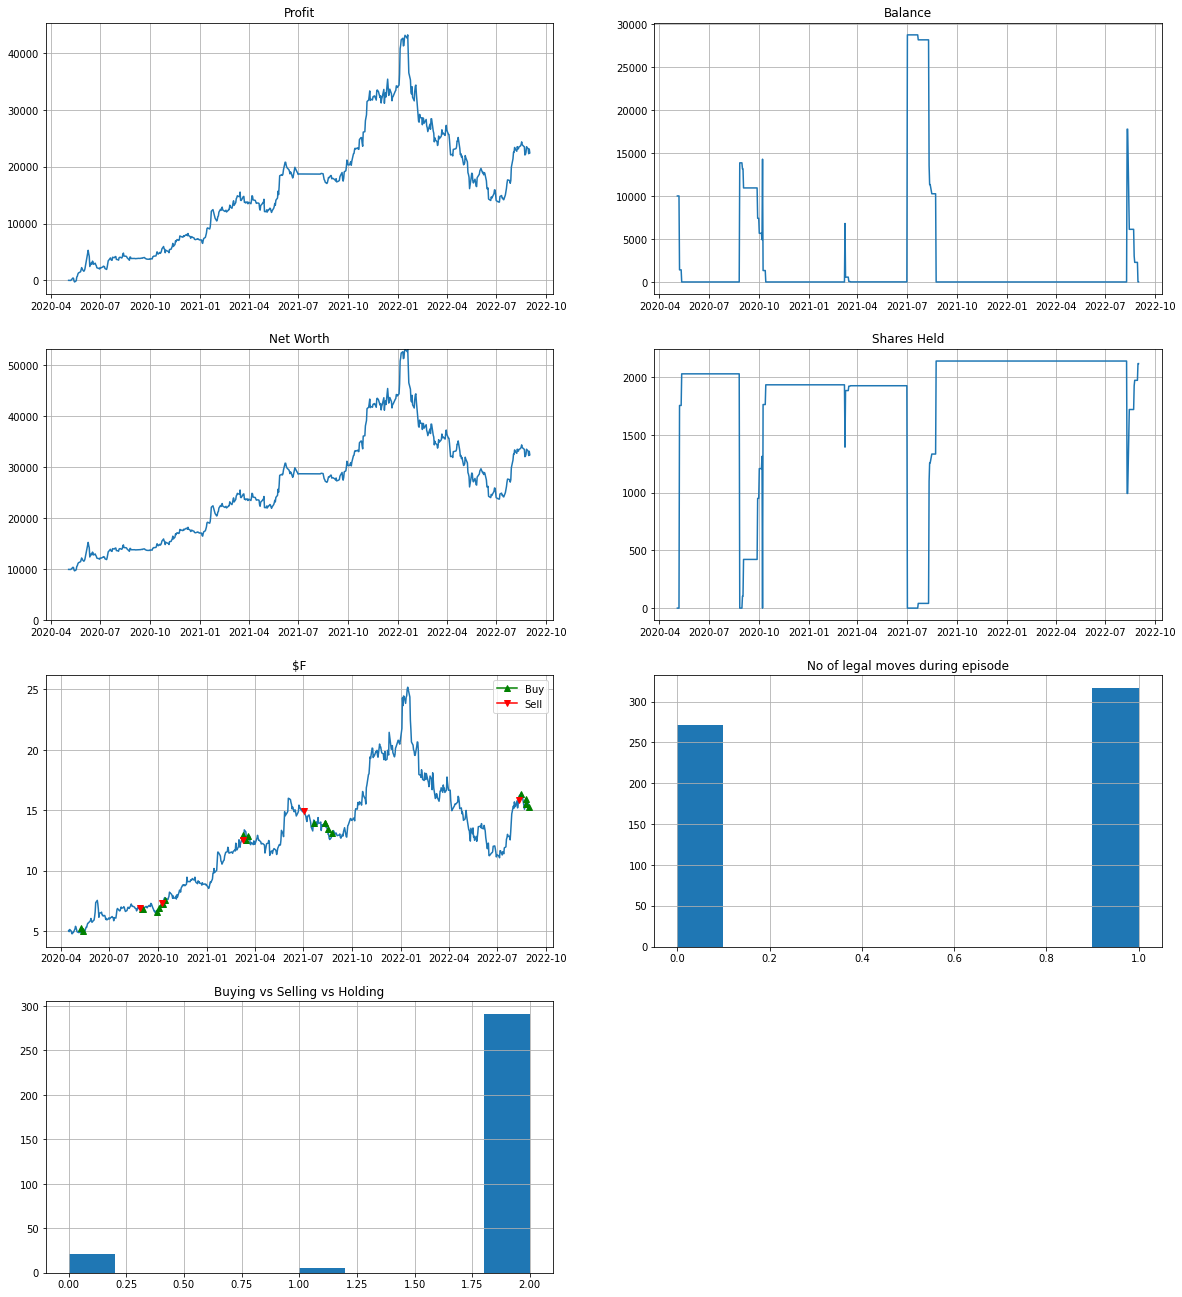

-------------------------
80000


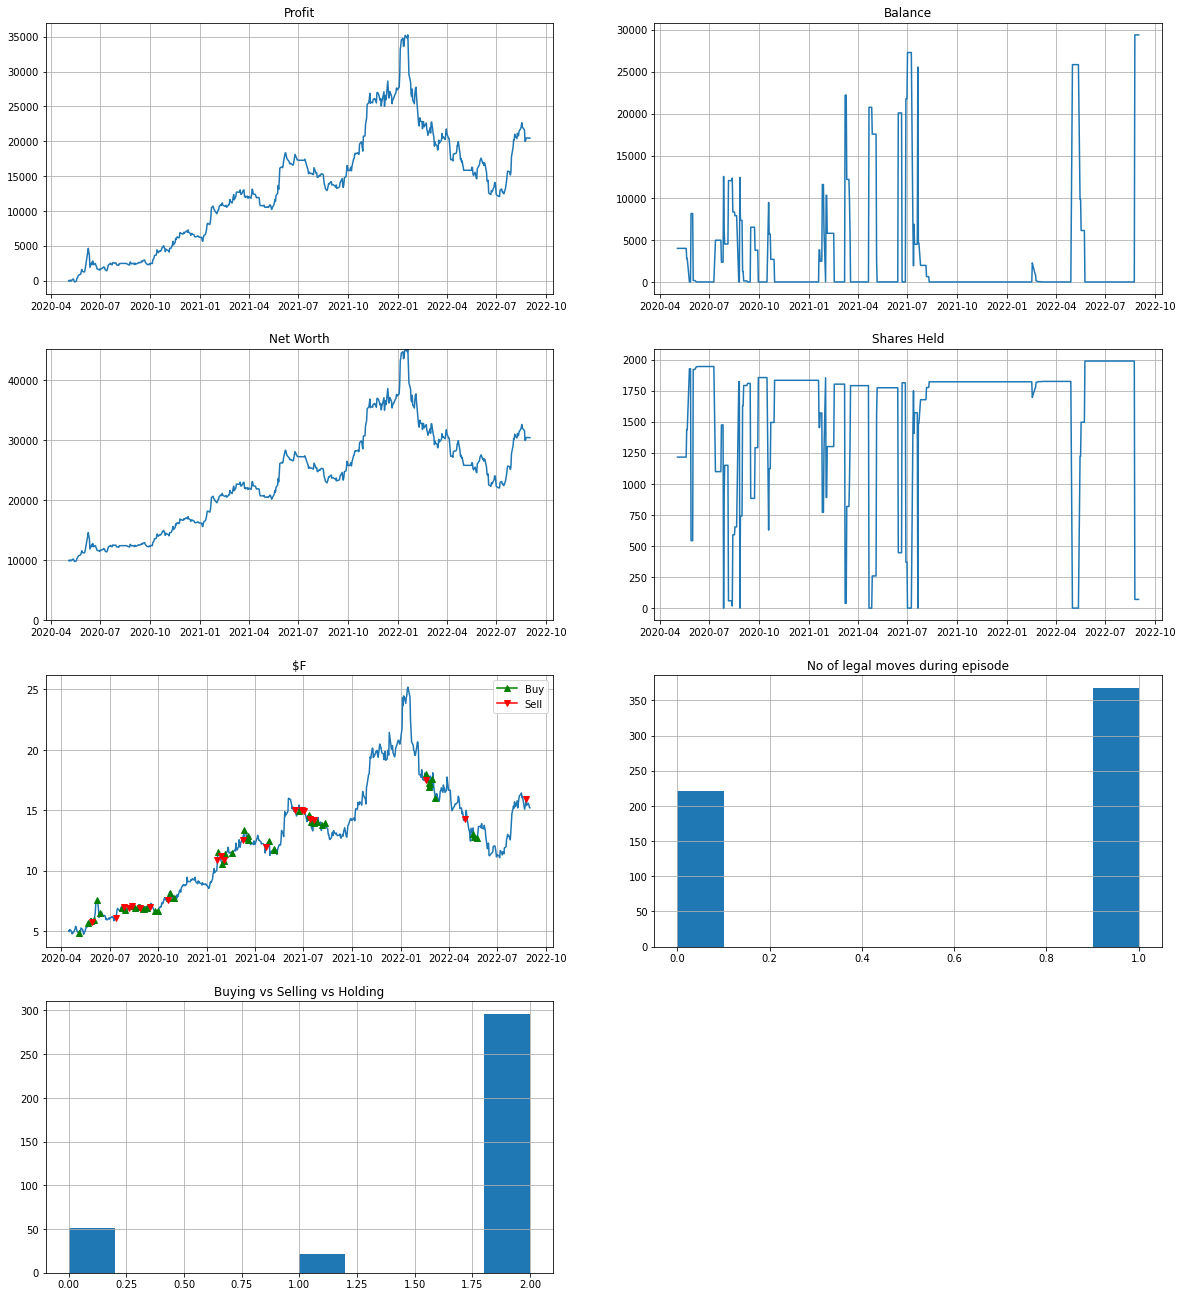

-------------------------
90000


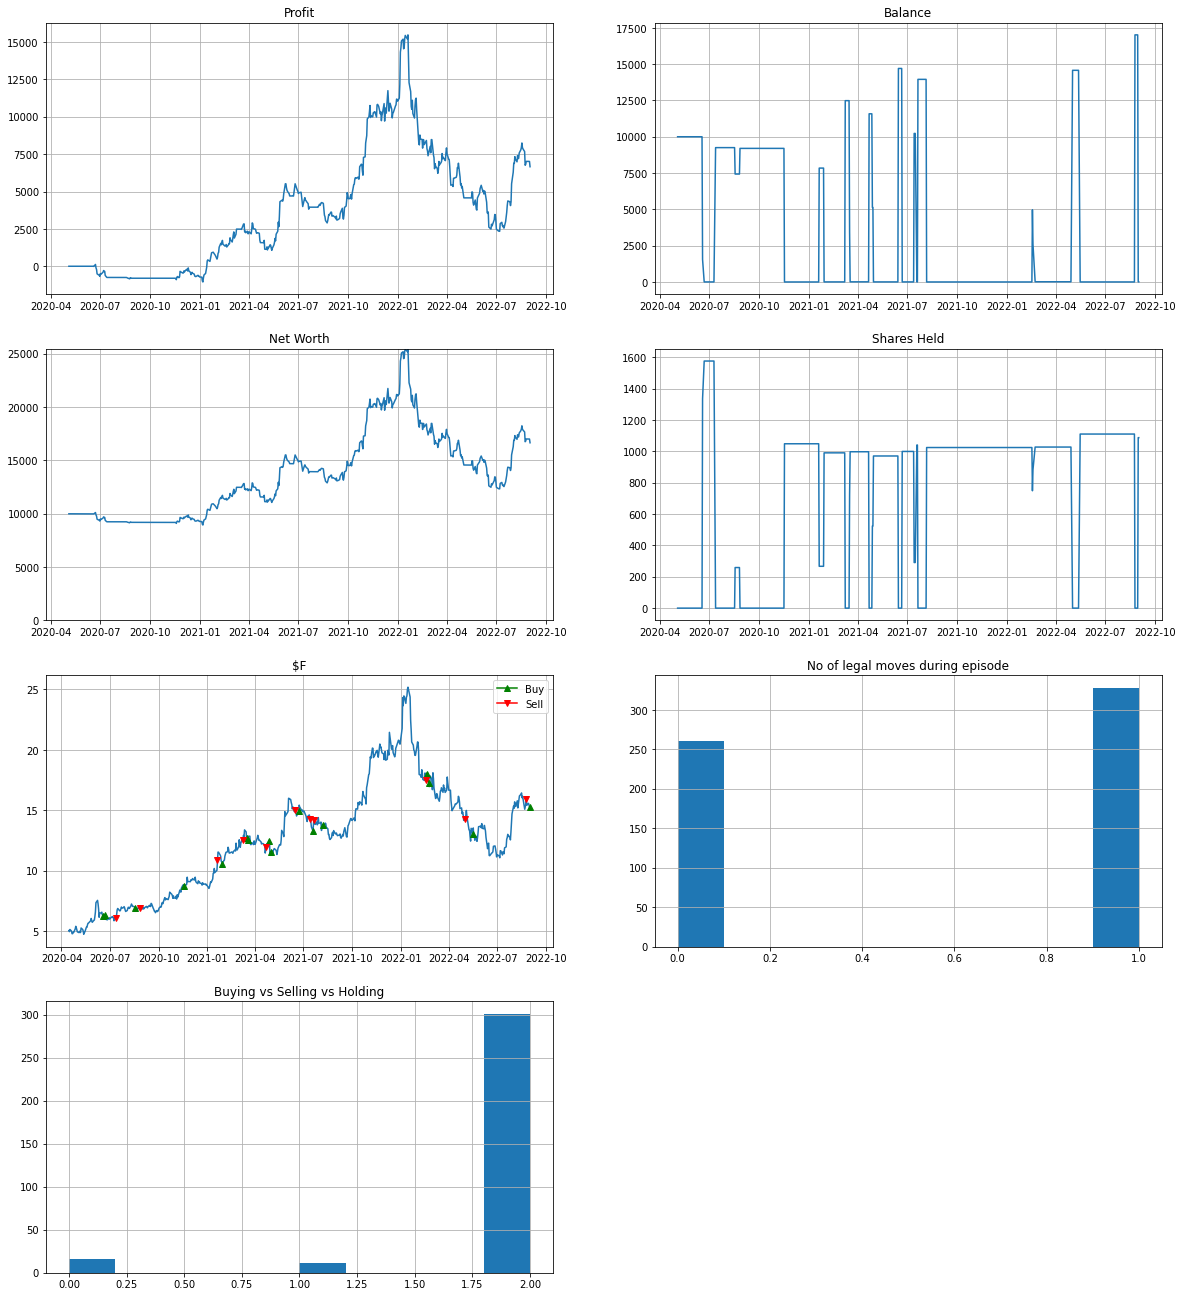

-------------------------
100000


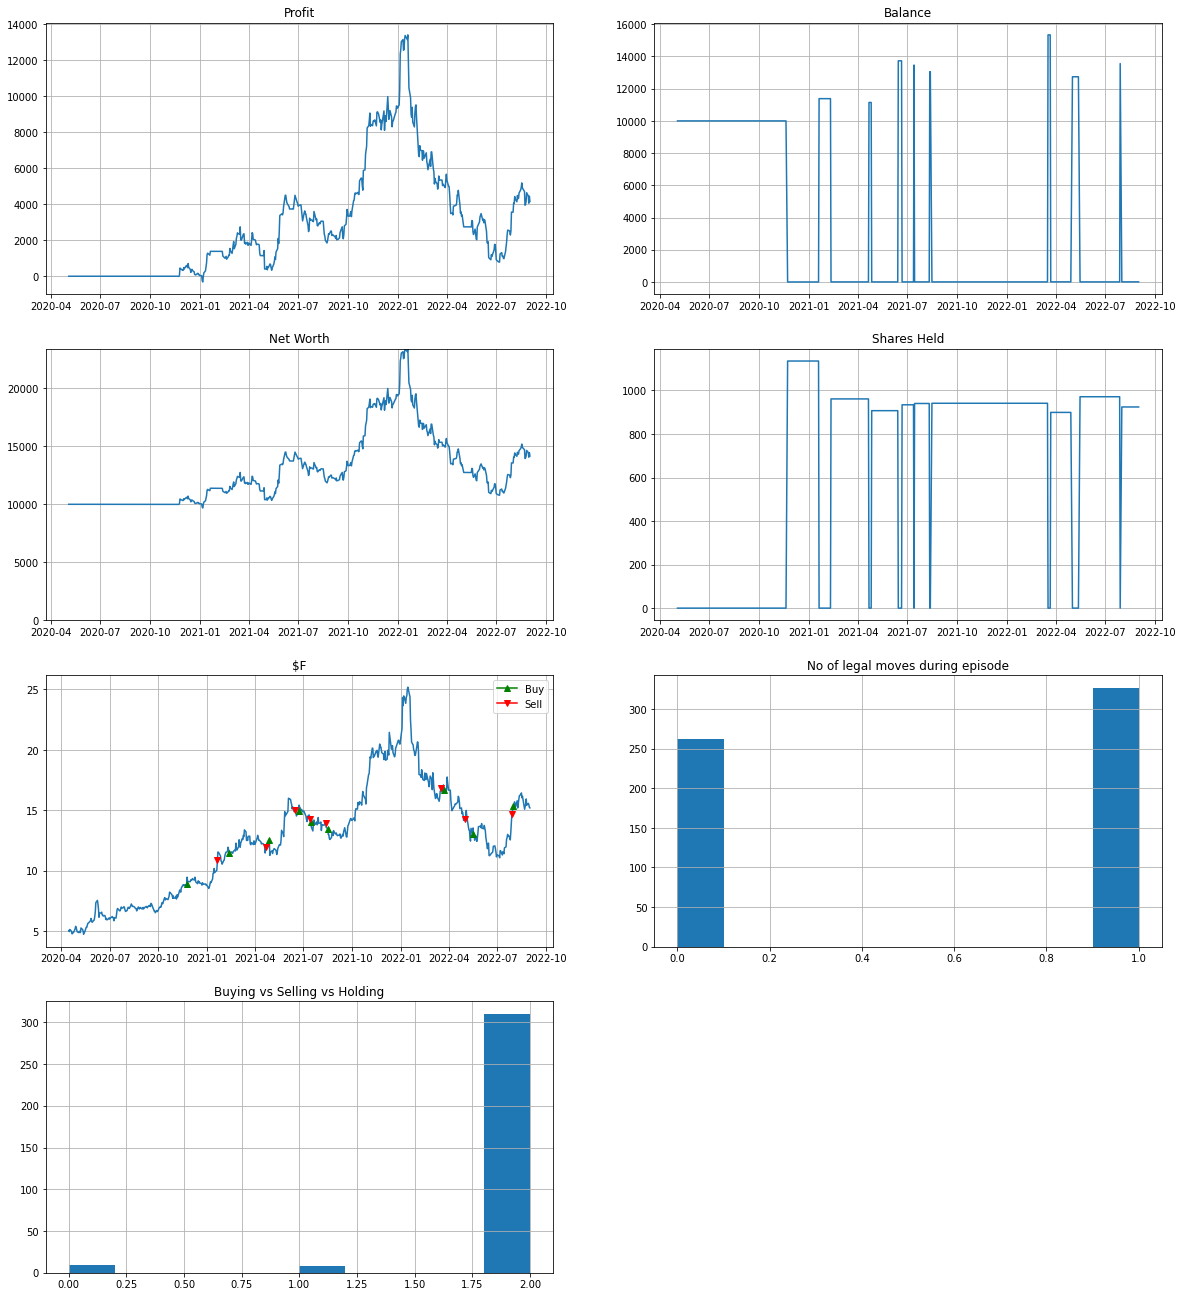

-------------------------
110000


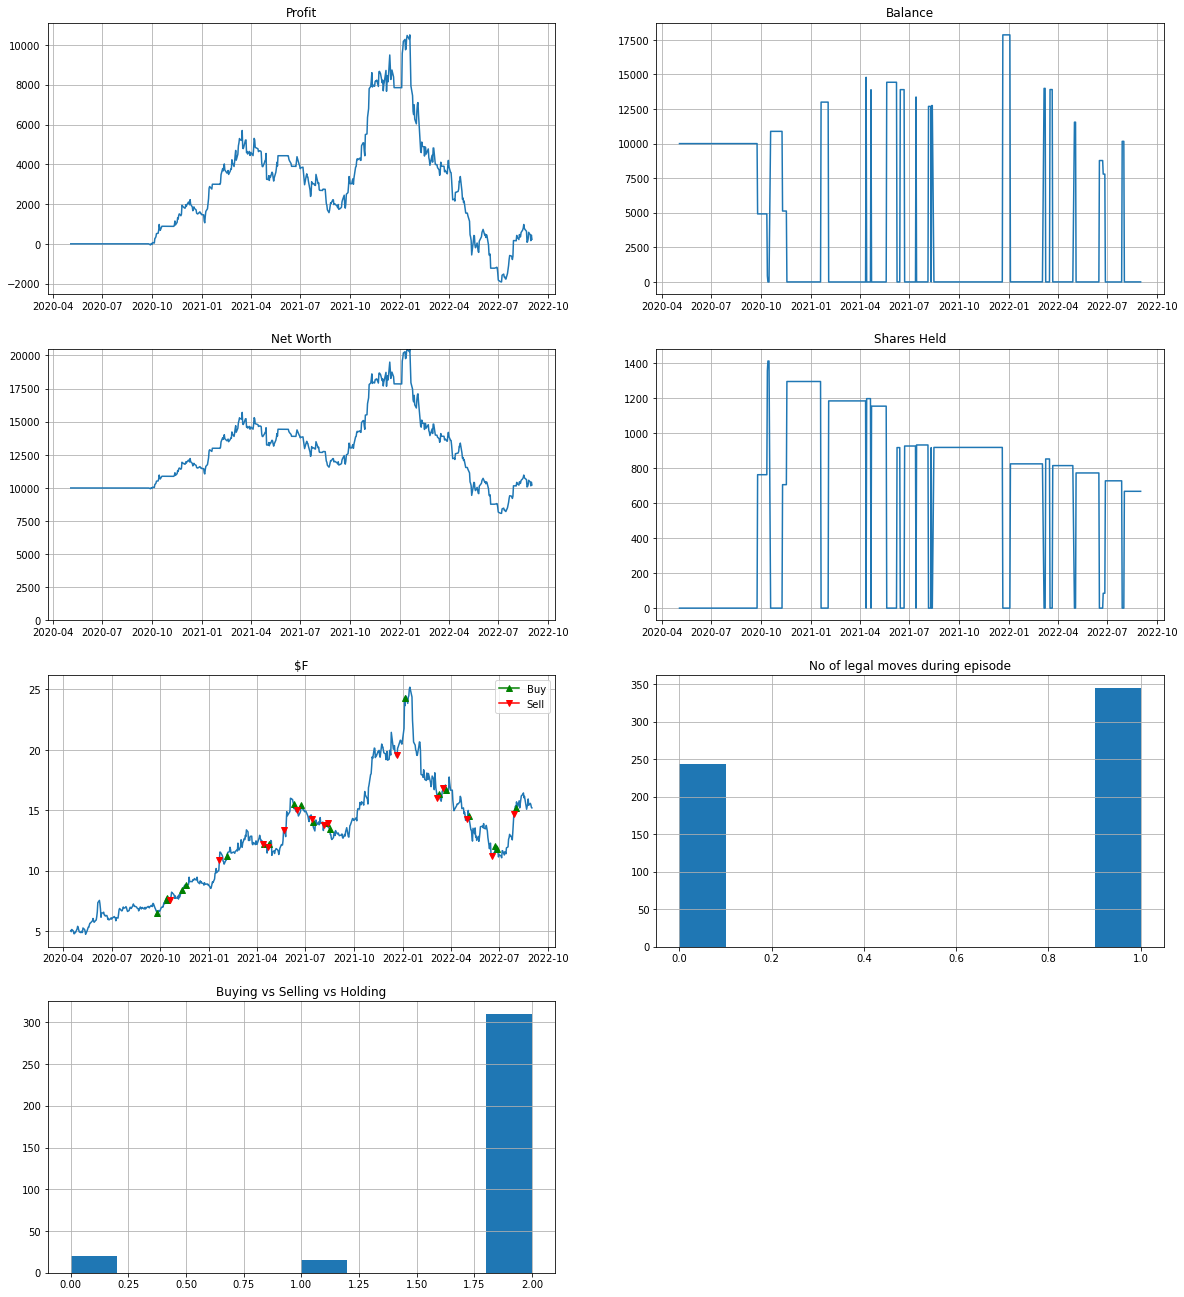

-------------------------
120000


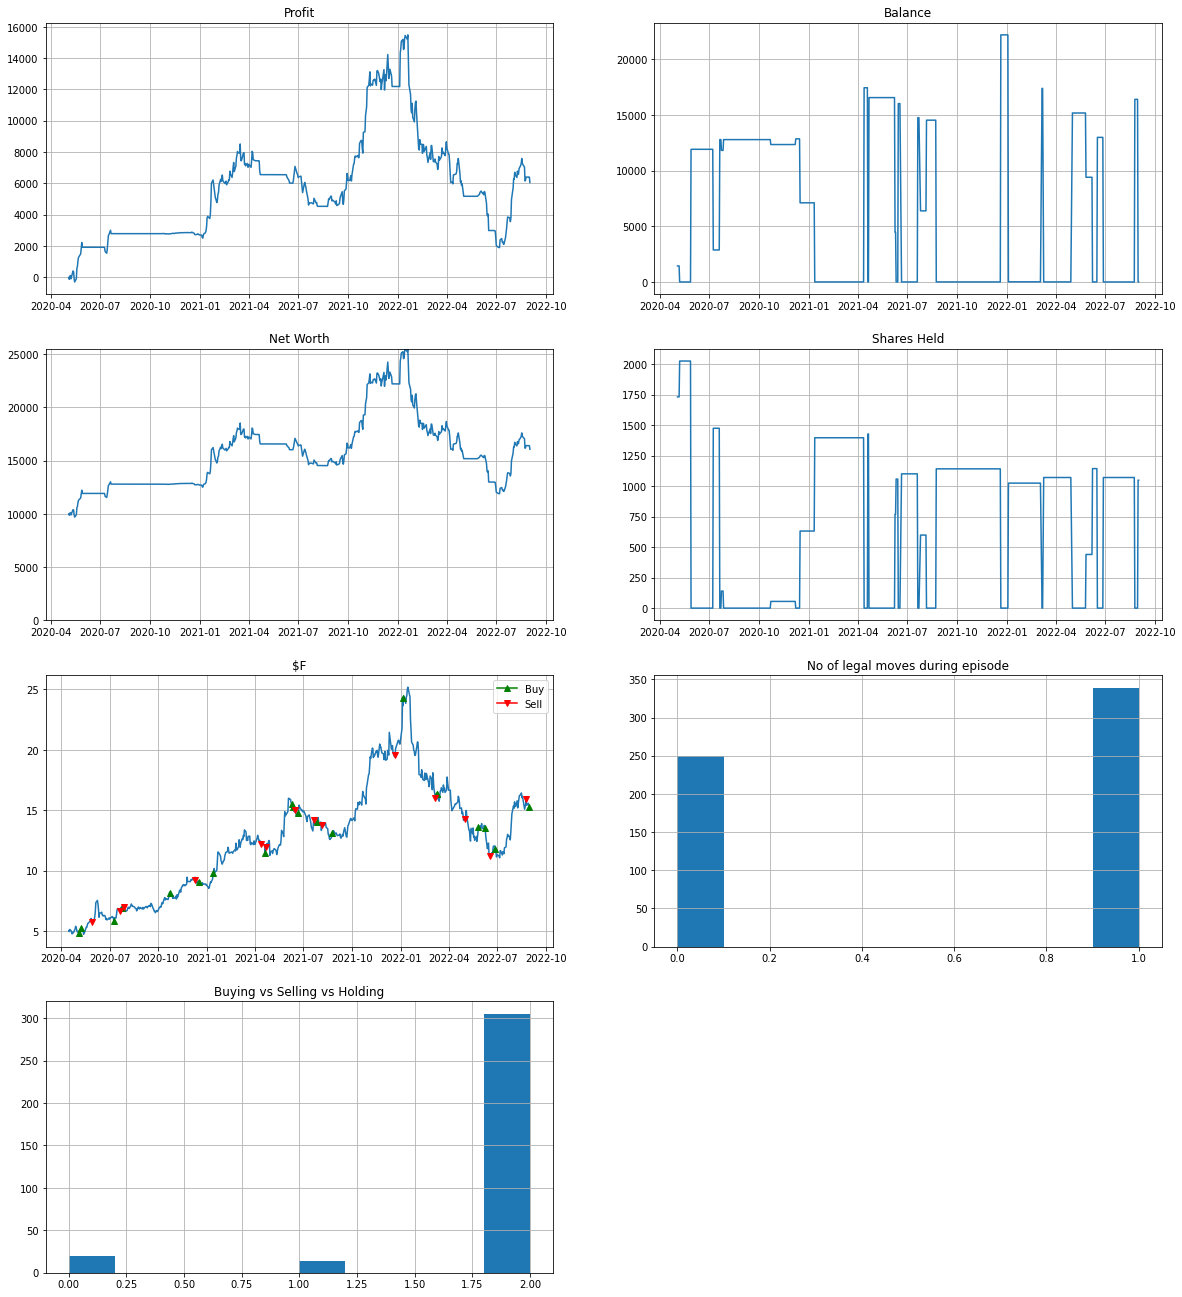

-------------------------
130000


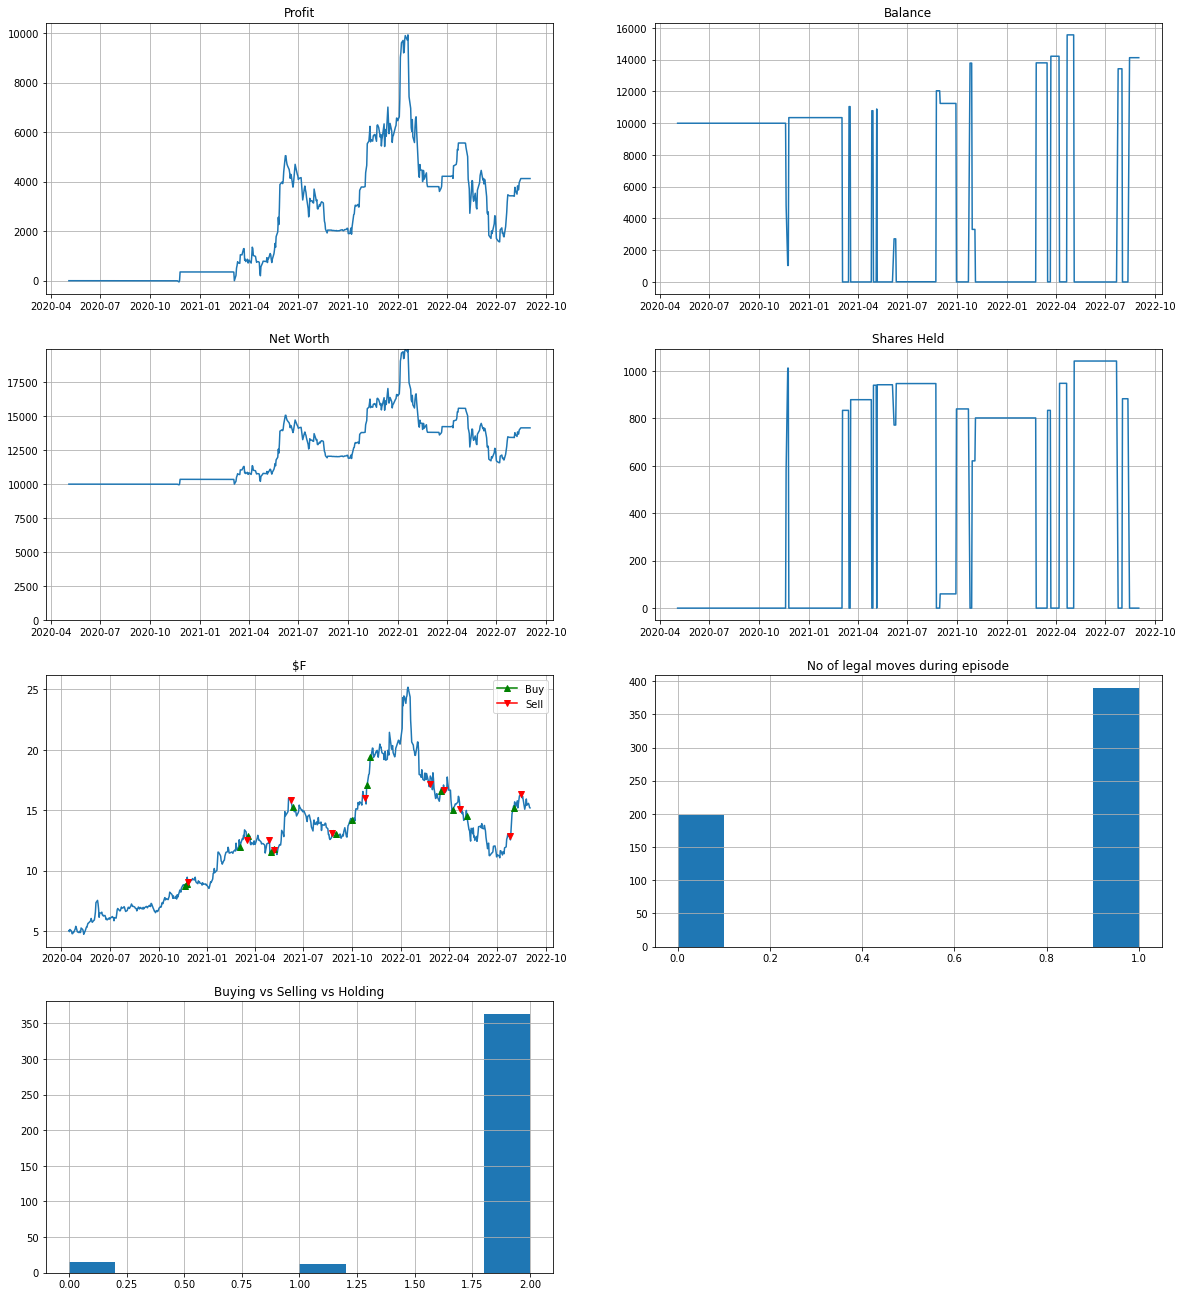

In [ ]:
from os import listdir                     #We run the training data on all the iterations we have saved for the model over the training steps, to test the learning of the model over the training steps, 
from os.path import isfile, join           #here we can chech that our best model have the best efficiency out of all the iterations    
mypath=models_dir+'/DQN1/'

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
for i in range(0,len(onlyfiles)):
  onlyfiles[i]=onlyfiles[i][:-4]
onlyfiles.sort(key=int)

train_env=StockTradingEnv(train_df,serial=True)
train_env.reset()

for i in range(0,len(onlyfiles)):
  print('-------------------------')
  print(onlyfiles[i])
  model=RecurrentPPO.load(f'{models_dir}/DQN1/'+onlyfiles[i])
  #model=DQN.load(mypath+onlyfiles[i])

  obs = train_env.reset()
  done=False
  while not done:
      action, _states = model.predict(obs)
      obs, rewards, done, info = train_env.step(action)
      train_env.render(action,done)

What we can see in the graphs is that the model with the best efficiency is the one with 40k steps of training, as before said. What we can see in the training data as in the test data is that our model with 40k steps of training have learned in some circunstances to buy the dip and be profitable, we can see that in the test, it only buys, but buys in the dip of the test data, which tells us that the model is promising.

Some of the things we can do to improve this model is to train the model with more steps, take other reward functions to enhance the behavior of the model (to sell and buy more frequently for example), take other financial features (improve our obervation space), to take other action space to buy on the close rather than only on the open price of the day. That are some of the things that first come to my mind to improve this model.